<a href="https://colab.research.google.com/github/heejjj/Health_Bio_AI/blob/bio_colab/0418_0419_heart_disease_planet_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#0418

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
#warnings 끄기, 경고를 표시X
import warnings
warnings.filterwarnings('ignore')

#xgboost의 경고를 끄기.
import xgboost as xgb
xgb.set_config(verbosity=0)

Practice - Heart Disease

In [ ]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import sys
if 'google.colab' in sys.modules:
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter02/heart_disease.csv

- target : binary value(1: 심장 질환 있는 사람 / 0:그렇지 않다)
- age : 나이
- sex : 성별(1=남성,0=여성)
- cp : 가슴 통증(chest pain) (1=전형적인 협심증, 2= 비전형적인 협심증, 3=협심증이 아닌 통증, 4=무증상)
- trestbps : 안정혈압 (입원시 mmHg)
- chol : 혈청 콜레스테롤(serum cholesterol)(mg/dl)
- fbs : 공복혈당 > 120 mg/dl (1=True, 0=False)
- restecg : 심전도 결과(0=정상, 1=ST-T파 이상)(T파 반전 및 또는 0.05mV 이상의 ST 상승 또는 감소), 2 = Estes 기준에 의해 좌심실 비대증 가능성 또는 유력
- thalach : 최대 심장 박동수
- exang : 운동으로 인한 협심증(1=yes, 2=no)
- oldpeak : 휴식 대비 운동으로 인한 ST 감소
- slope : 최대 운동 ST 세그먼트 기울기(1=상승 기울기, 2=수평,3=하강 기울기)
- ca : 형광 투시로 착색된 주요 혈관(0-3)
- thal : 탈륨 스트레스 테스트(3=정상, 6=고정 결합, 7=가역적 결함)

In [ ]:
import pandas as pd
# heart_disease.csv를 데이터프레임으로 로드합니다.
df_heart = pd.read_csv('heart_disease.csv')

# 처음 다섯 개 행을 출력합니다.
df_heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
! pip install -U pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.9/345.9 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 27.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.8/679.8 kB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 60.5 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27096 sha256=d1ee636feaa64b90d796831ffaed241dd327db18501c94

In [ ]:
import pandas_profiling
pr = df_heart.profile_report()
pr

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#남성1 207, 여성0 96 
#trestbps: 이상치 제거 / 왼쪽으로 치우침, 95th percential 160 -> 
#col =  400이상 제거하기 


In [ ]:
pr.to_file('./pr_heart_report.html') 
#report html저장

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df = df_heart

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [ ]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [ ]:
df_heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
X = df_heart.iloc[:, :-1]
y = df_heart.iloc[:, -1]
y

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: target, Length: 303, dtype: int64

In [ ]:
print(y_test.unique())

[0 1]


In [ ]:
from collections import Counter
Counter(y_train)
#https://www.daleseo.com/python-collections-counter/
#Counter 생성자에 문자열을 인자로 넘기면 각 문자가 문자열에서 몇 번씩 나타나는지를 알려주는 객체가 반환됨


Counter({0: 103, 1: 124})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [ ]:
mean_squared_error(y_test, y_pred, suared=False)

In [ ]:
from xgboost import XGBRegressor
xgb_reg = XGBRegressor()

In [ ]:
xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

In [ ]:
rmse = np.sqrt(mse)
rmse

0.3979956583384858

In [ ]:
xgb_reg.score(X_train, y_train)

0.9999926997393253

In [ ]:
#Rd search cv: 범위를 줘야함 
#permutation_importance: shuffle시켜서 보는것 

#gridsearch에서 정수가 달라짐? 

In [ ]:
#####################################################

In [ ]:
#DecisionTreeClassifier 객체 만들기
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=2)

#교차 검증 점수 계산 
scores = cross_val_score(model, X, y, cv=5)

#정확도 출력
print('정확도:', np.round(scores,2))

#평균 정확도 출력
print('정확도 평균: %0.2f' % (scores.mean()))

정확도: [0.74 0.85 0.77 0.73 0.7 ]
정확도 평균: 0.76


-  RandomizedSearchCV
    - RandomizedSearchCV는 GridSearch 와 동일한 방식으로 사용하지만 모든 조합을 다 시도하지는 않고, 각 반복마다 임의의 값만 대입해 지정한 횟수만큼 평가합니다.

    - 즉, 몇 번 학습과 평가를 반복할 것인지 시도의 수를 우리가 설정할 수 있기 때문에 비교적 시간이 적게 걸립니다.
        - param_distributions : 튜닝을 위한 대상 파라미터, 사용될 파라미터를 딕셔너리 형태로 넣어준다.

        - n_iter : 파라미터 검색 횟수

In [ ]:
# RandomizedSearchCV를 임포트합니다.
from sklearn.model_selection import RandomizedSearchCV

def randomized_search_clf(params, runs=20, clf=DecisionTreeClassifier(random_state=2)):

    # RandomizedSearchCV 객체를 만듭니다.
    rand_clf = RandomizedSearchCV(clf, params, n_iter=runs, 
                                  cv=5, n_jobs=-1, random_state=2)
    
    # X_train와 y_train에서 랜덤 서치를 수행합니다.
    rand_clf.fit(X_train, y_train)

    # 최상의 모델을 추출합니다.
    best_model = rand_clf.best_estimator_
    
    # 최상의 점수를 추출합니다.
    best_score = rand_clf.best_score_

    # 최상의 점수를 출력합니다.
    print("훈련 점수: {:.3f}".format(best_score))

    # 테스트 세트에 대한 예측을 만듭니다.
    y_pred = best_model.predict(X_test)

    # 정확도를 계산합니다.
    accuracy = accuracy_score(y_test, y_pred)

    # 정확도를 출력합니다.
    print('테스트 점수: {:.3f}'.format(accuracy))
        
    # 최상의 모델을 반환합니다.
    return best_model

- hyperparameter tuning

In [ ]:
#from sklearn.metrics import accuracy_score
randomized_search_clf(
    params={
        'criterion':['entropy', 'gini'],
        'splitter':['random', 'best'],
        'min_samples_split':[2, 3, 4, 5, 6, 8, 10],
        'min_samples_leaf':[1, 0.01, 0.02, 0.03, 0.04],
        'min_impurity_decrease':[0.0, 0.0005, 0.005, 0.05, 0.10, 0.15, 0.2],
        'max_leaf_nodes':[10, 15, 20, 25, 30, 35, 40, 45, 50, None],
        'max_features':['sqrt', 0.95, 0.90, 0.85, 0.80, 0.75, 0.70],
        'max_depth':[None, 2,4,6,8],
        'min_weight_fraction_leaf':[0.0, 0.0025, 0.005, 0.0075, 0.01, 0.05]
    })

훈련 점수: 0.824
테스트 점수: 0.763


DecisionTreeClassifier(max_depth=4, max_features='sqrt', max_leaf_nodes=30,
                       min_impurity_decrease=0.0005, min_samples_split=10,
                       min_weight_fraction_leaf=0.05, random_state=2)

- 탐색 범위 좁히기

In [ ]:
best_model = randomized_search_clf(
    params={'max_depth':[None, 6, 7],
            'max_features':['sqrt', 0.78],
            'max_leaf_nodes':[45, None],
            'min_samples_leaf':[1, 0.035, 0.04, 0.045, 0.05],
            'min_samples_split':[2, 9, 10],
            'min_weight_fraction_leaf': [0.0, 0.05, 0.06, 0.07],
            },
    runs=100)

훈련 점수: 0.824
테스트 점수: 0.803


In [ ]:
# 교차 검증 점수를 계산
scores = cross_val_score(best_model, X, y, cv=5)

# 정확도를 출력
print('정확도:', np.round(scores, 2))

# 평균 정확도를 출력
print('정확도 평균: %0.2f' % (scores.mean()))

정확도: [0.82 0.9  0.8  0.8  0.78]
정확도 평균: 0.82


- log-uniform(로그 균등분포)를 사용한 random_search
    - scipy의 randint, uniform 같은 샘플링 가능한 분포에서 매개변수 값을 탐색할 수 있음.
    - 매개변수 값이 연속적이고 임의의 간격을 지정하기 어려울때 도움이 됨.

    - max_depth와 max_leaf_nodes는 정수값을 받는다.

In [ ]:
from sklearn.utils.fixes import loguniform
from scipy.stats import randint

params = {'max_depth': randint(1,100),
          'max_leaf_nodes': randint(1,100),
          'max_features': loguniform(1e-5,1),
          'min_samples_split': loguniform(1e-5,1),
          'min_samples_leaf': loguniform(1e-5,1),
          'min_impurity_decrease': loguniform(1e-5,1),
          'min_weight_fraction_leaf': loguniform(1e-5,1)}

dtc = DecisionTreeClassifier(random_state=0)
rs = RandomizedSearchCV(dtc, params, n_iter=100, n_jobs=-1, random_state=0)
rs.fit(X_train, y_train)

print('최상의 교차 검증 점수:', rs.best_score_)
print('최상의 매개변수:', rs.best_params_)

최상의 교차 검증 점수: 0.8194202898550724
최상의 매개변수: {'max_depth': 48, 'max_features': 0.43091880545542754, 'max_leaf_nodes': 68, 'min_impurity_decrease': 0.0013196080073784372, 'min_samples_leaf': 0.005935250363740932, 'min_samples_split': 0.00027243167437771866, 'min_weight_fraction_leaf': 0.03410935690756259}


- Feature Importance

In [ ]:
best_model.fit(X,y)

DecisionTreeClassifier(max_depth=7, max_features=0.78, max_leaf_nodes=45,
                       min_samples_leaf=0.045, min_samples_split=9,
                       min_weight_fraction_leaf=0.06, random_state=2)

In [ ]:
best_model.feature_importances_

array([0.04826754, 0.04081653, 0.48409586, 0.00568635, 0.        ,
       0.        , 0.        , 0.00859483, 0.        , 0.02690379,
       0.        , 0.18069065, 0.20494446])

In [ ]:
# 열과 feature_importances_를 딕셔너리로 묶습니다.
feature_dict = dict(zip(X.columns, best_model.feature_importances_))

# operator를 임포트합니다.
import operator

# 튜플에 있는 값을 기준으로 딕셔너리를 정렬합니다.
sorted(feature_dict.items(), key=operator.itemgetter(1), reverse=True)[0:3]

[('cp', 0.4840958610240171),
 ('thal', 0.20494445570568706),
 ('ca', 0.18069065321397942)]

- cp : 가슴 통증(chest pain) (1=전형적인 협심증, 2= 비전형적인 협심증, 3=협심증이 아닌 통증, 4=무증상)
- thalach : 최대 심장 박동수
- ca : 형광 투시로 착색된 주요 혈관(0-3)

- permutation_importance / 참고 : https://hong-yp-ml-records.tistory.com/51
    - 특정 feature의 데이터를 shuffle 했을 때, 검증 데이터 셋에 대한 예측성능을 확인하고 feature importance를 계산한다.

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_model, X, y, n_jobs=-1, random_state=0)

feature_dict = dict(zip(X.columns, result.importances_mean))
sorted(feature_dict.items(), key=operator.itemgetter(1), reverse=True)[0:3]

[('cp', 0.08976897689768981),
 ('thal', 0.08382838283828387),
 ('ca', 0.05940594059405944)]

## Bagging & RandomForest
 - RF는 bagging사용
 - XGBoost는 boosting 기법 사용

In [ ]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import sys
if 'google.colab' in sys.modules:
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter03/census_cleaned.csv
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter03/bike_rentals_cleaned.csv

In [ ]:
import pandas as pd
import numpy as np
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_census = pd.read_csv('census_cleaned.csv')

#데이터를 X와 y로 나눔
X_census = df_census.iloc[:,:-1]
y_census = df_census.iloc[:,-1]

In [ ]:
df_census.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,income_ >50K
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_census.columns

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_ ?', 'workclass_ Federal-gov',
       'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ State-gov', 'workclass_ Without-pay',
       'marital-status_ Divorced', 'marital-status_ Married-AF-spouse',
       'marital-status_ Married-civ-spouse',
       'marital-status_ Married-spouse-absent',
       'marital-status_ Never-married', 'marital-status_ Separated',
       'marital-status_ Widowed', 'occupation_ ?', 'occupation_ Adm-clerical',
       'occupation_ Armed-Forces', 'occupation_ Craft-repair',
       'occupation_ Exec-managerial', 'occupation_ Farming-fishing',
       'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct',
       'occupation_ Other-service', 'occupation_ Priv-house-serv',
       'occupation_ Prof-specialty', 'occupation_ Protective-serv',
     

In [ ]:
df_census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 93 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   age                                         32561 non-null  int64
 1   fnlwgt                                      32561 non-null  int64
 2   education-num                               32561 non-null  int64
 3   capital-gain                                32561 non-null  int64
 4   capital-loss                                32561 non-null  int64
 5   hours-per-week                              32561 non-null  int64
 6   workclass_ ?                                32561 non-null  int64
 7   workclass_ Federal-gov                      32561 non-null  int64
 8   workclass_ Local-gov                        32561 non-null  int64
 9   workclass_ Never-worked                     32561 non-null  int64
 10  workclass_ Private                

In [ ]:
df_census.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,income_ >50K
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,...,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456,0.056386,0.029483,0.064279,0.000215,...,0.003501,0.000369,0.002457,0.001566,0.000553,0.000584,0.895857,0.002058,0.000491,0.240810
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429,0.230670,0.169159,0.245254,0.014661,...,0.059068,0.019194,0.049507,0.039546,0.023506,0.024149,0.305451,0.045316,0.022162,0.427581
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#랜덤 포레스트 모델을 만듦.
rf = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)

#교차 검증 수행
scores = cross_val_score(rf,X_census,y_census,cv=5)

#정확도 측정
print('정확도 : ',np.round(scores,3))

#정확도 측정
print('정확도의 평균: %0.3f ' %(scores.mean()))

정확도 :  [0.847 0.848 0.855 0.854 0.853]
정확도의 평균: 0.851 


##  Hyperparameter
- n_estimators: 랜덤 포레스트 안의 결정 트리 갯수

 - n_estimators는 클수록 좋습니다.
 - 결정 트리가 많을수록 더 깔끔한 Decision Boundary가 나오겠죠.
 - 하지만 그만큼 메모리와 훈련 시간이 증가합니다.
Default는 10입니다.
 - max_features: 무작위로 선택할 Feature의 개수

-  max_features=n_features이면 30개의 feature 중 30개의 feature 모두를 선택해 결정 트리를 만듭니다.
단, bootstrap=True이면 30개의 feature에서 복원 추출로 30개를 뽑습니다.
-  특성 선택의 무작위성이 없어질 뿐 샘플링의 무작위성은 그대로인 것입니다.
-  bootstrap=True는 default 값입니다.
-  따라서 max_features 값이 크다면 랜덤 포레스트의 트리들이 매우 비슷해지고, 가장 두드러진 특성에 맞게 예측을 할 것입니다.
-  max_features 값이 작다면 랜덤 포레스트의 트리들이 서로 매우 달라질 것입니다. 따라서 오버피팅이 줄어들 것입니다.
-  max_features는 일반적으로 Defalut 값을 씁니다.
-  max_depth : 트리의 깊이를 뜻합니다.

-  min_samples_leaf : 리프노드가 되기 위한 최소한의 샘플 데이터 수 입니다.

-  min_samples_split : 노드를 분할하기 위한 최소한의 데이터 수 입니다.

-  max_leaf_nodes : 리프노드의 최대 개수

- A Random Forest is an ensemble of decision trees. Each decision tree will reach a "conclusion" (i.e., a prediction) about each observation. All trees are then combined together.

- What does it mean?

  - if you are training a Random Forest regressor, this combination is an average of each tree's prediction.
  - if you are training a Random Forest classifier, each tree's classification is combined into a final classification through a "majority vote" mechanism.

- 랜덤포레스트 회귀 모델

In [ ]:
df_bikes = pd.read_csv('bike_rentals_cleaned.csv')

# 처음 다섯 개 행을 출력합니다.
df_bikes.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1.0,0.0,1.0,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1.0,0.0,1.0,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,1.0,0.0,1.0,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,1.0,0.0,1.0,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,1.0,0.0,1.0,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,1600


In [ ]:
#데이터와 X와 y를 나눕니다.
X_bikes = df_bikes.iloc[:,:-1]
y_bikes = df_bikes.iloc[:,-1]
# RandomForestRegressor를 임포트합니다.
from sklearn.ensemble import RandomForestRegressor

# RandomForestRegressor 객체를 만듭니다.
rf = RandomForestRegressor(n_estimators=10, random_state=2, n_jobs=-1)

# 평균 제곱 오차를 사용해 교차 검증을 수행합니다.
scores = cross_val_score(rf, X_bikes, y_bikes, scoring='neg_mean_squared_error', cv=10)

# 오차의 제곱근을 계산합니다.
rmse = np.sqrt(-scores) # = (mean_squared_error(y_test,y_pred))**0.5
 
# rmse를 출력합니다.
print('RMSE:', np.round(rmse, 3))

# 평균 rmse를 출력합니다.
print('RMSE 평균: %0.3f' % (rmse.mean()))

RMSE: [ 801.486  579.987  551.347  846.698  895.05  1097.522  893.738  809.284
  833.488 2145.046]
RMSE 평균: 945.365


- oob_scores (Out of bags)
    - 랜덤 포레스트는 중복을 허용한 샘플링인 배깅을 통해 결정 트리를 만듭니다. 모든 샘플 중 일부 샘플은 선택되지 않고 남아 있게 됨. -> 이런 샘플을 테스트 세트로 사용할 수 있음.
    - oob_scores = True로 설정하면 랜덤 포레스트 모델을 훈련한 후 각 트리에서 사용되지 않은 샘플을 사용해 개별 트리의 예측 점수를 누적하여 평균을 냄

In [ ]:
#데이터와 X와 y를 나눕니다.
X_bikes = df_bikes.iloc[:,:-1]
y_bikes = df_bikes.iloc[:,-1]
# RandomForestRegressor를 임포트합니다.
from sklearn.ensemble import RandomForestRegressor

# RandomForestRegressor 객체를 만듭니다.
rf = RandomForestRegressor(oob_score=True,n_estimators=50, random_state=2, n_jobs=-1)

# 평균 제곱 오차를 사용해 교차 검증을 수행합니다.
scores = cross_val_score(rf, X_bikes, y_bikes, scoring='neg_mean_squared_error', cv=10)

# 오차의 제곱근을 계산합니다.
rmse = np.sqrt(-scores) # = (mean_squared_error(y_test,y_pred))**0.5
 
# rmse를 출력합니다.
print('RMSE:', np.round(rmse, 3))

# 평균 rmse를 출력합니다.
print('RMSE 평균: %0.3f' % (rmse.mean()))

RMSE: [ 836.482  541.898  533.086  812.782  894.877  881.117  794.103  828.968
  772.517 2128.148]
RMSE 평균: 902.398


In [ ]:
rf = RandomForestClassifier(oob_score=True, n_estimators=10, random_state=2, n_jobs=-1)
#인구 조사 데이터셋으로 모델을 훈련
rf.fit(X_census,y_census)

RandomForestClassifier(n_estimators=10, n_jobs=-1, oob_score=True,
                       random_state=2)

In [ ]:
#oob_score
rf.oob_score_

0.8343109855348423

- n_estimators

In [ ]:
# n_estimators=50과 oob_score=True로 RandomForestClassifier를 만듭니다.
rf = RandomForestClassifier(n_estimators=50, oob_score=True, random_state=2, n_jobs=-1)

# 인구 조사 데이터셋으로 모델을 훈련합니다.
rf.fit(X_census, y_census)

# oob_score_를 출력합니다.
rf.oob_score_

0.8518780135745216

In [ ]:
# n_estimators=100과 oob_score=True로 RandomForestClassifier를 만듭니다.
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=2, n_jobs=-1)

# 인구 조사 데이터셋으로 모델을 훈련합니다.
rf.fit(X_census, y_census)

# oob_score_를 출력합니다.
rf.oob_score_

0.8551334418476091

- **warm_start**
    - 랜덤 포레스트는 랜덤 포레스트의 트리 갯수(n_estimators)를 결정하는데 도움이 됨.
    - warm_start = True로 지정하면 처음부터 시작하지 않고 트리를 앙상블에 추가할 수 있음.
    - n_estimators를 100에서 200으로 바꾸면 200개의 트리를 가진 랜덤 포레스트를 만드는데 두 배 오래 걸림.
    - warm_start = True로 지정하면 처음부터 200개의 트리를 다시 만들지 않고 이전 모델에 이어서 트리를 추가함.
    - warm_start를 매개변수로 사용해 n_estimators에 따라 OOB점수 변화를 그래프로 그릴 수 있음.

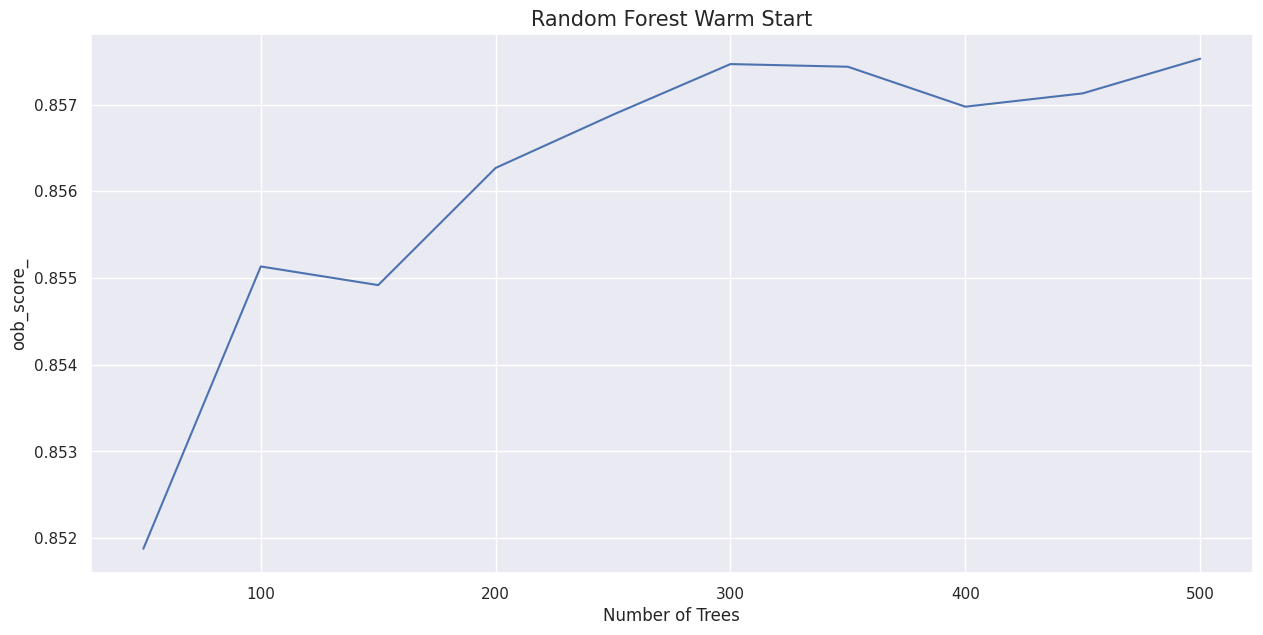

In [ ]:
# matplotlib 임포트
import matplotlib.pyplot as plt

# seaborn 임포트
import seaborn as sns

# seaborn을 darkgrid로 설정합니다.
sns.set()

# 빈 oob_scores 리스트를 만듭니다.
oob_scores = []

# n_estimators=50, warm_start=True, oob_score=True로 RandomForestClassifier 객체를 만듭니다.
rf = RandomForestClassifier(n_estimators=50, warm_start=True, 
                            oob_score=True, n_jobs=-1, random_state=2)

# 인구 조사 데이터셋으로 모델을 훈련합니다.
rf.fit(X_census, y_census)

# rf.oob_score_를 oob_scores 리스트에 추가합니다.
oob_scores.append(rf.oob_score_)

# est를 50으로 초기화합니다.
est = 50

# est로 estimators 리스트를 초기화합니다.
estimators=[est]

# 0~9까지 반복합니다.
for i in range(9):
    
    # est에 50을 더합니다.
    est += 50
    
    # est를 estimators 리스트에 추가합니다.
    estimators.append(est)

    # n_estimators를 est로 설정합니다.
    rf.set_params(n_estimators=est)
    
    # 인구 조사 데이터셋으로 훈련합니다.
    rf.fit(X_census, y_census)
    
    # rf.oob_score를 oob_scores 리스트에 추가합니다.
    oob_scores.append(rf.oob_score_)

# 그래프 크기를 설정합니다.
plt.figure(figsize=(15,7))

# estimators와 oob_scores를 그래프로 그립니다.
plt.plot(estimators, oob_scores)

# x 축 레이블을 설정합니다.
plt.xlabel('Number of Trees')

# y 축 레이블을 설정합니다.
plt.ylabel('oob_score_')

# 제목을 출력합니다.
plt.title('Random Forest Warm Start', fontsize=15)

# 그래프를 출력합니다.
plt.show()

- 트리 개수 300에서 점수가 가장 높다. 300개 이상 트리를 사용하는 것은 비용과 시간 낭비이며 얻을 수 있는 이득이 크지 않음.

- bootstrap
    - 랜덤 포레스트는 일반적으로 bootstrap을 사용하지만 boostrap 매개변수를 False로 지정할 수 있음. boostrap=FALSE로 지정하면 oob_score_속성이 만들어 지지 않음.
     - OOB 점수는 boostrap되지 않은 남은 샘플로 계산이 됨.

- verbose
    - 실행 과정 출력 여부(=0 기본값, 대규모 모델을 만들 때는 verbose=1로 선언함)

- class_wight
    - 클래스 별로 가중치를 부여할 수 있는 class_wight 매개변수 제공.
    - 기본값은 None으로 클래스별 가중치를 부여하지 않음.
- max_samples
    - training set 크기를 지정할 수 있음.
    - 기본값 None, 원본 훈련 세트와 동일한 크기의 bootstrap sample을 만듦.
    - 정수로 지정할 수 있고 0~1사이의 실수로 원본 세트 크기의 비율을 지정할 수 있음.

- ExtraTreesClassifier
    -  앞서 본 Random Forest는 각 노드의 분할을 위해 feature의 subset을 사용했습니다. 트리를 더욱 무작위하게 만들기 위해 최적의 임곗값 t_k
를 찾는 대신 feature의 subset을 사용해 무작위로 분할 후 그중 최상의 분할을 선택합니다.

    - 이렇게 극단적으로 무작위한 Random Forest를 Extreme random Tree 앙상블 혹은 Extra tree라고 부릅니다. 이 역시 무작위성은 다양성을 늘려 편향을 늘리는 대신 분산을 줄이게 됩니다.

    - 기존엔 노드 분할 시 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 많이 시간을 잡아먹는 부분이었는데 이것이 없어졌으므로 일반적인 Random Forest보다 Extra Tree가 훨씬 빠릅니다.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_validate

X_train, X_test, y_train, y_test = train_test_split(X_census, y_census, random_state=2)
et = ExtraTreesClassifier(n_estimators=100, random_state=2, n_jobs=-1)
cv_results = cross_validate(et, X_train, y_train)

print('교차 검증 평균 점수:', np.mean(cv_results['test_score']))

교차 검증 평균 점수: 0.8415642915642916


# RF 성능 높이기
  - bike_rental data

In [ ]:
# bike_rentals_cleaned.csv 파일을 로드합니다.
df_bikes = pd.read_csv('bike_rentals_cleaned.csv')

# 처음 다섯 개 행을 출력합니다.
df_bikes.head()

FileNotFoundError: ignored

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_validate

X_train, X_test, y_train, y_test = train_test_split(X_census, y_census, random_state=2)
et = ExtraTreesClassifier(n_estimators=100, random_state=2, n_jobs=-1)
cv_results = cross_validate(et, X_train, y_train)

print('교차 검증 평균 점수:', np.mean(cv_results['test_score']))

교차 검증 평균 점수: 0.8415642915642916


- n_estimators
    - n_estimators를 증가시키면 시간과 계산 비용이 늘어나지만 정확도 향상을 시킬 수 있음.
     - n_estimators=50이 합리적인 시작점


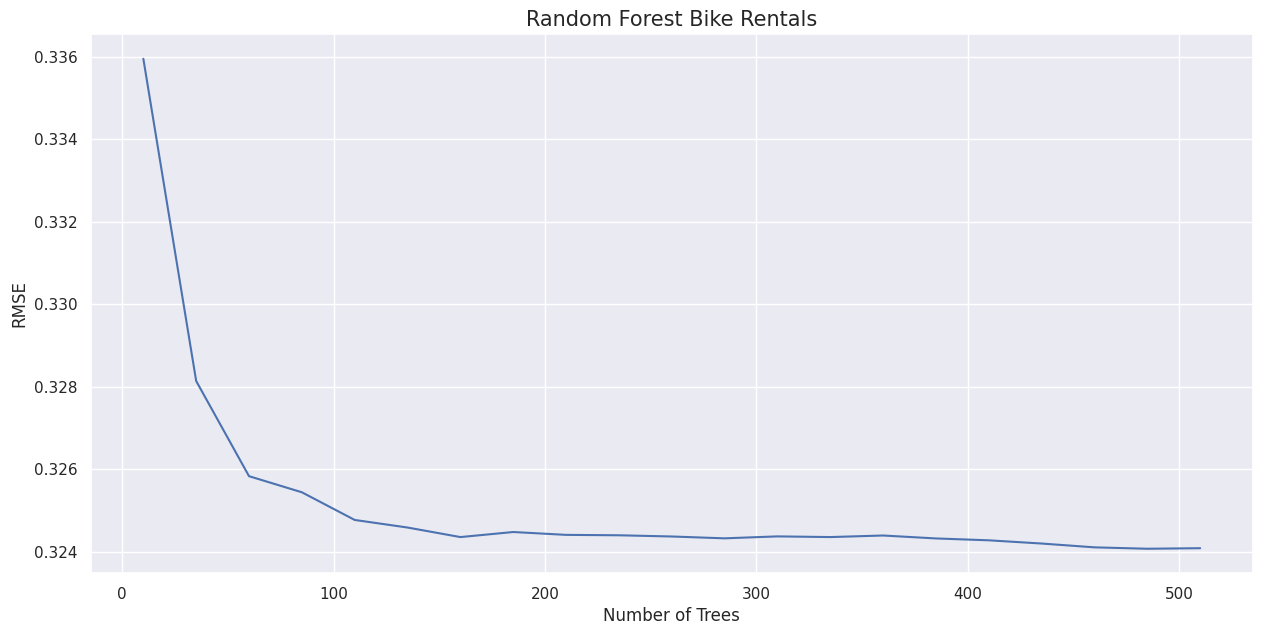

In [ ]:
from sklearn.metrics import mean_squared_error

# MSE 점수와 트리 개수를 담을 리스트
rmse_scores = []
estimators = []

# warm_start=True로 RandomForestRegressor 객체를 만듭니다.
rf = RandomForestRegressor(warm_start=True, n_jobs=-1, random_state=2)

# 시작 트리 개수
est = 10

# 0~19까지 반복합니다.
for i in range(21):
    
    # n_estimators를 est로 설정합니다.
    rf.set_params(n_estimators=est)
    
    # 인구 조사 데이터셋으로 훈련합니다.
    rf.fit(X_train, y_train)
    
    # RMSE 값을 계산합니다.
    rmse = mean_squared_error(y_test, rf.predict(X_test), squared=False)
    
    # rmse와 est를 리스트에 추가합니다.
    rmse_scores.append(rmse)
    estimators.append(est)
    
    # 트리를 25개씩 늘립니다.
    est += 25

# 그래프 크기를 설정합니다.
plt.figure(figsize=(15,7))

# estimators와 oob_scores를 그래프로 그립니다.
plt.plot(estimators, rmse_scores)

# 축 레이블을 설정합니다.
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')

# 제목을 출력합니다.
plt.title('Random Forest Bike Rentals', fontsize=15)

# 그래프를 출력합니다.
plt.show()

In [ ]:
# n_estimators=50, warm_start=True, oob_score=True로 랜덤 포레스트 모델을 만듭니다.
rf = RandomForestRegressor(n_estimators=50, warm_start=True, 
                           n_jobs=-1, random_state=2)
   
# 평균 제곱 오차를 사용해 교차 검증을 수행합니다.
scores = cross_val_score(rf, X_bikes, y_bikes, 
                         scoring='neg_mean_squared_error', cv=10)
    
# 오차의 제곱근을 계산합니다.
rmse = np.sqrt(-scores)
    
# rmse를 출력합니다.
print('RMSE:', np.round(rmse, 3))

# 평균 rmse를 출력합니다.
print('RMSE 평균: %0.3f' % (rmse.mean()))

RMSE: [ 836.482  541.898  533.086  812.782  894.877  881.117  794.103  828.968
  772.517 2128.148]
RMSE 평균: 902.398


- Hyperparameter tuning

In [ ]:
# RandomizedSearchCV 임포트
from sklearn.model_selection import RandomizedSearchCV

def randomized_search_reg(params, runs=16, 
                          reg=RandomForestRegressor(random_state=2, n_jobs=-1)):

    # RandomizedSearchCV 객체를 만듭니다.
    rand_reg = RandomizedSearchCV(reg, params, n_iter=runs, scoring='neg_mean_squared_error', 
                                  cv=10, n_jobs=-1, random_state=2)
    
    # X_train와 y_train로 grid_reg를 훈련합니다.
    rand_reg.fit(X_train, y_train)

    # 최상의 모델을 추출합니다.
    best_model = rand_reg.best_estimator_

    # 최상의 매개변수를 추출합니다.
    best_params = rand_reg.best_params_

    # 최상의 매개변수를 출력합니다.
    print("최상의 매개변수:", best_params)
    
    # 최상의 점수를 구합니다.
    best_score = np.sqrt(-rand_reg.best_score_)

    # 최상의 점수를 출력합니다.
    print("훈련 점수: {:.3f}".format(best_score))

    # 테스트 세트의 레이블을 예측합니다.
    y_pred = best_model.predict(X_test)
    
    # mean_squared_error를 임포트합니다.
    from sklearn.metrics import mean_squared_error as MSE

    # rmse를 계산합니다.
    rmse_test = MSE(y_test, y_pred)**0.5

    # rmse를 출력합니다.
    print('테스트 세트 점수: {:.3f}'.format(rmse_test))

In [ ]:
randomized_search_reg(
    params={'min_weight_fraction_leaf':[0.0, 0.0025, 0.005, 0.0075, 0.01, 0.05],
            'min_samples_split':[2, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08, 0.1],
            'min_samples_leaf':[1,2,4,6,8,10,20,30],
            'min_impurity_decrease':[0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
            'max_leaf_nodes':[10, 15, 20, 25, 30, 35, 40, 45, 50, None],
            'max_features':['sqrt', 0.8, 0.7, 0.6, 0.5, 0.4],
            'max_depth':[None,2,4,6,8,10,20]})

최상의 매개변수: {'min_weight_fraction_leaf': 0.0, 'min_samples_split': 0.04, 'min_samples_leaf': 30, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 40, 'max_features': 0.8, 'max_depth': 20}
훈련 점수: 0.314
테스트 세트 점수: 0.320


In [ ]:
randomized_search_reg(
    params={'min_samples_leaf':[1,2,4,6,8,10,20,30],
            'min_impurity_decrease':[0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
            'max_features':['sqrt', 0.8, 0.7, 0.6, 0.5, 0.4],
            'max_depth':[None,2,4,6,8,10,20]})

최상의 매개변수: {'min_samples_leaf': 10, 'min_impurity_decrease': 0.0, 'max_features': 0.6, 'max_depth': 4}
훈련 점수: 0.325
테스트 세트 점수: 0.330


In [ ]:
randomized_search_reg(
    params={'min_samples_leaf':[1,2,4,6,8,10,20,30],
            'min_impurity_decrease':[0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
            'max_features':['sqrt', 0.8, 0.7, 0.6, 0.5, 0.4],
            'max_depth':[None,4,6,8,10,12,15,20]}, 
    runs=20)

In [ ]:
randomized_search_reg(
    params={'min_samples_leaf':[1,2,3,4,5,6],
            'min_impurity_decrease':[0.0, 0.01, 0.05, 0.08, 0.10, 0.12, 0.15],
            'max_features':['sqrt', 0.8, 0.7, 0.6, 0.5, 0.4],
            'max_depth':[None,8,10,12,14,16,18,20]})

최상의 매개변수: {'min_samples_leaf': 3, 'min_impurity_decrease': 0.0, 'max_features': 0.5, 'max_depth': 10}
훈련 점수: 0.306
테스트 세트 점수: 0.313


In [ ]:
randomized_search_reg(
    params={'min_samples_leaf':[1,2,4,6,8,10,20,30],
            'min_impurity_decrease':[0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
            'max_features':['sqrt', 0.8, 0.7, 0.6, 0.5, 0.4],
            'max_depth':[None,4,6,8,10,12,15,20],
            'n_estimators':[100]}, 
    runs=20)

최상의 매개변수: {'n_estimators': 100, 'min_samples_leaf': 8, 'min_impurity_decrease': 0.0, 'max_features': 0.6, 'max_depth': 12}
훈련 점수: 0.306
테스트 세트 점수: 0.313


In [ ]:
# n_estimators=100, oob_score=True으로 랜덤 포레스트 모델을 만듭니다.
rf = RandomForestRegressor(n_estimators=100, min_impurity_decrease=0.1, 
                           max_features=0.6, max_depth=12, n_jobs=-1, 
                           random_state=2)
   
# 평균 제곱 오차를 사용해 교차 검증을 수행합니다.
scores = cross_val_score(rf, X_bikes, y_bikes, 
                         scoring='neg_mean_squared_error', cv=10)
    
# 오차의 제곱근을 계산합니다.
rmse = np.sqrt(-scores)
    
# rmse를 출력합니다.
print('RMSE:', np.round(rmse, 3))

# 평균 rmse를 출력합니다.
print('RMSE 평균: %0.3f' % (rmse.mean()))

RMSE: [ 818.354  514.173  547.392  814.059  769.54   730.025  831.376  794.634
  756.83  1595.237]
RMSE 평균: 817.162


In [ ]:
df_bikes.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1.0,0.0,1.0,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1.0,0.0,1.0,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,1.0,0.0,1.0,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,1.0,0.0,1.0,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,1.0,0.0,1.0,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,1600


In [ ]:
#데이터를 섞으면 효과가 있을까?

from sklearn.utils import shuffle
df_shuffle_bikes = shuffle(df_bikes, random_state=2)
df_shuffle_bikes.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
671,672,4.0,1.0,11.0,0.0,5.0,1.0,1,0.355000,0.356042,0.522083,0.266175,5847
199,200,3.0,0.0,7.0,0.0,2.0,1.0,1,0.776667,0.747479,0.650417,0.130600,4541
77,78,1.0,0.0,3.0,0.0,6.0,0.0,1,0.472500,0.466525,0.379167,0.368167,3117
225,226,3.0,0.0,8.0,0.0,0.0,0.0,2,0.676667,0.624388,0.817500,0.222633,3820
37,38,1.0,0.0,2.0,0.0,1.0,1.0,1,0.271667,0.303658,0.738333,0.045408,1712


In [ ]:
# 데이터를 X와 y로 나눕니다.
X_shuffle_bikes = df_shuffle_bikes.iloc[:,:-1]
y_shuffle_bikes = df_shuffle_bikes.iloc[:,-1]

In [ ]:
# n_estimators=100, oob_score=True로 랜덤 포레스트 모델을 만듭니다.
rf = RandomForestRegressor(n_estimators=100, min_impurity_decrease=0.1, 
                           max_features=0.6, max_depth=12, n_jobs=-1, 
                           random_state=2)
   
# 평균 제곱 오차를 사용해 교차 검증을 수행합니다.
scores = cross_val_score(rf, X_shuffle_bikes, y_shuffle_bikes, 
                         scoring='neg_mean_squared_error', cv=10)
    
# 오차의 제곱근을 계산합니다.
rmse = np.sqrt(-scores)
    
# rmse를 출력합니다.
print('RMSE:', np.round(rmse, 3))

# 평균 rmse를 출력합니다.
print('RMSE 평균: %0.3f' % (rmse.mean()))

RMSE: [630.093 686.673 468.159 526.676 593.033 724.575 774.402 672.63  760.253
 616.797]
RMSE 평균: 645.329


- 랜덤 포레스트의 단점
    - 개별 트리에 제약이 됨. -> 모든 트리가 동일한 실수를 하면, 랜덤 포레스트도 실수를 하게 됨.
    - 개별 트리가 해결할 수 없는 데이터 내의 문제 때문에 랜덤 포레스트의 성능이 향상이 안되는 경우도 많음.
    - 트리의 실수로부터 배워서 초반의 단점을 개선할 수 있는 앙상블 방법이 도움이 될 수도 있음. -> 부스팅은 저지른 실수에서 배우도록 설계를 함.

## 4장. 그래디언트 부스팅과 xgboost까지
- 랜덤포레스트는 bootstrap 샘플을 사용하기 때문에 배깅 알고리즘으로 분류
- 부스팅은 개별 트리의 실수로부터 학습을 진행. 이전 트리의 오차를 기반으로 새로운 트리를 훈련하는 것이 기본적인 아이디어.

- 부스팅에서 새로운 트리에 대한 오차를 수정하는 것은 배깅과 다른 점.

- Adaboost
    - Adaboost는 가중치를 부여한 약 분류기(Weak Classifier)를 모아서 최종적인 강 분류기(Strong Classifier)를 생성하는 기법
    - 새로운 트리가 이전 트리의 오차를 기반으로 가중치 조정
    - 오류 샘플의 가중치를 높여 잘못된 예측에 더 많은 주의를 기울임.
    - 실수에서 학습하기 때문에 약한 학습기를 강력한 학습기로 만들 수 있음.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_validate

X_train, X_test, y_train, y_test = train_test_split(X_census, y_census, random_state=2)
et = AdaBoostClassifier(n_estimators=100, random_state=2)
cv_results = cross_validate(et, X_train, y_train)

print('교차 검증 평균 점수:', np.mean(cv_results['test_score']))

NameError: ignored

- Gradient Boosting model
    - 이전 트리의 예측 오차를 기반으로 완전히 새로운 트리를 훈련함.
    - 각 트리의 실수를 살펴보고, 이런 실수에 대한 완전한 새로운 트리를 만듦.
    - 새로운 올바르게 예측된 값에는 영향을 받지 않음.
    - 오차에만 초점을 맞추는 머신러닝 알고리즘을 만들려면, 정확한 최종 예측을 만들기 위해 오차를 계산하는 방법이 필요-> 모델의 예측과 실제 값 사이의 차이인 잔차(Residual)를 활용함.ㅡ

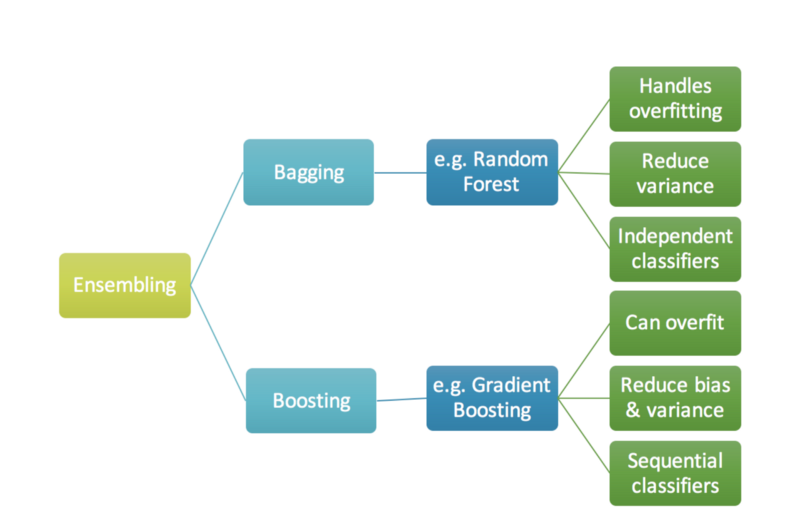


In [ ]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import sys
if 'google.colab' in sys.modules:
    !pip install -q --upgrade xgboost
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter04/bike_rentals_cleaned.csv
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter04/exoplanets.csv.zip

!unzip -o exoplanets.csv.zip

- 그래디언트 부스팅 작동 방식
    - 자전거 대여 데이터셋 로드하기

In [ ]:
# pandas와 numpy 임포트하기
import pandas as pd
import numpy as np

# 경고 끄기
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
xgb.set_config(verbosity=0)

In [ ]:
df_bikes = pd.read_csv('bike_rentals_cleaned.csv')
df_bikes.head()

In [ ]:
# 데이터를 X와 y로 나눕니다.
X_bikes = df_bikes.iloc[:,:-1]
y_bikes = df_bikes.iloc[:,-1]

# train_test_split를 임포트합니다.
from sklearn.model_selection import train_test_split

# 데이터를 훈련 세트와 테스트 세트로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X_bikes, y_bikes, random_state=2)

- 그래디언트 부스팅 모델 작동 원리

In [ ]:
# DecisionTreeRegressor를 임포트합니다.
from sklearn.tree import DecisionTreeRegressor

# DecisionTreeRegressor를 초기화합니다.
tree_1 = DecisionTreeRegressor(max_depth=2, random_state=2)

# 훈련 세트에 결정 트리를 훈련합니다.
tree_1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

- 기본 학습기라 부르는 결정 트리는 높은 정확도를 위해 튜닝하지 않음.
- 기본 학습기에 크게 의존하는 모델이 아니라 오차에서 학습하는 모델을 원하기 때문이다.

In [ ]:
# 훈련 세트에 대한 예측을 만듭니다.
y_train_pred = tree_1.predict(X_train)

In [ ]:
# 잔차를 계산합니다.
y2_train = y_train - y_train_pred

# DecisionTreeRegressor를 초기화합니다.
tree_2 = DecisionTreeRegressor(max_depth=2, random_state=2)

# 잔차에 모델을 훈련합니다.
tree_2.fit(X_train, y2_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [ ]:
# 훈련 세트에 대한 예측을 만듭니다.
y2_train_pred = tree_2.predict(X_train)

# 잔차를 계산합니다.
y3_train = y2_train - y2_train_pred

# DecisionTreeRegressor를 초기화합니다.
tree_3 = DecisionTreeRegressor(max_depth=2, random_state=2)

# 잔차에 모델을 훈련합니다.
tree_3.fit(X_train, y3_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [ ]:
y1_pred = tree_1.predict(X_test)

y2_pred = tree_2.predict(X_test)

y3_pred = tree_3.predict(X_test)

y_pred = y1_pred + y2_pred + y3_pred

# mean_squared_error를 임포트합니다.
from sklearn.metrics import mean_squared_error as MSE

# 평균 제곱근 오차를 계산합니다.
MSE(y_test, y_pred)**0.5

0.3389042323279019

- 사이킷런의 그래디언트 부스팅 알고리즘
    - 타깃과 앙상블 모델의 예측 사이에 손실 함수를 정의하고 이 손실을 최소화 하도록 트리를 추가함. 이를 위해 손실 함수의 그래디언트를 계산함.
    - 경사하강법로 두 함수를 미분하면 모두 y- y_pred꼴을 얻을 수 있음.

- 사이킷런의 GradientBoostingRegressor, GradientBoostingClassifier는 init 매개변수에서 초기 모델을 지정할 수 있음.

In [ ]:
res_1 = y_train - np.mean(y_train)

In [ ]:
tree_1.fit(X_train, res_1)
pred_1 = tree_1.predict(X_train)
res_2 = y_train - pred_1

In [ ]:
tree_2.fit(X_train, res_2)
pred_2 = tree_2.predict(X_train)
res_3 = y_train - (pred_1 + pred_2)

In [ ]:
tree_3.fit(X_train, res_3)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [ ]:
from sklearn.metrics import mean_squared_error

pred_all = tree_1.predict(X_test) + tree_2.predict(X_test) + tree_3.predict(X_test)
mean_squared_error(y_test, pred_all, squared=False)

0.3389042323279026

- GradientBoostingClassifier의 경우 클래스별로 각 트리의 예측을 더한 후 시그모이드 함수를 적용하여 예측 확률을 계산합니다.


- 사이킷런으로 그레이디언트 부스팅 모델 만들기

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=3, 
                                random_state=2, learning_rate=1.0)

gbr.fit(X_train, y_train)

# 테스트 데이터에 대한 예측을 만듭니다.
y_pred = gbr.predict(X_test)

# 평균 제곱근 오차를 계산합니다.
MSE(y_test, y_pred)**0.5

0.3389042323279026

In [ ]:
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=30, 
                                random_state=2, learning_rate=1.0)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred)**0.5

0.3169635062794412

In [ ]:
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=300, 
                                random_state=2, learning_rate=1.0)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred)**0.5

0.31520461694201185

In [ ]:
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=300, random_state=2)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred)**0.5

0.31328938152418956

#### 그래디언트 부스팅 매개변수 튜닝

- learning_rate
    - 개별 트리의 영향을 제한. 일반적으로 트리 개수인 n_estimators를 늘리면 learning_rate는 줄여야 함.

In [ ]:
learning_rate_values = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1.0]
for value in learning_rate_values:
    gbr = GradientBoostingRegressor(max_depth=2, n_estimators=300, 
                                    random_state=2, learning_rate=value)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = MSE(y_test, y_pred)**0.5
    print('학습률:', value, ', 점수:', rmse)

학습률: 0.001 , 점수: 0.39784649914079884
학습률: 0.01 , 점수: 0.3304151347935251
학습률: 0.05 , 점수: 0.31671699835871286
학습률: 0.1 , 점수: 0.31328938152418956
학습률: 0.15 , 점수: 0.3105156854158474
학습률: 0.2 , 점수: 0.3097493689133623
학습률: 0.3 , 점수: 0.3065700173132749
학습률: 0.5 , 점수: 0.307844318761675
학습률: 1.0 , 점수: 0.31520461694201185


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

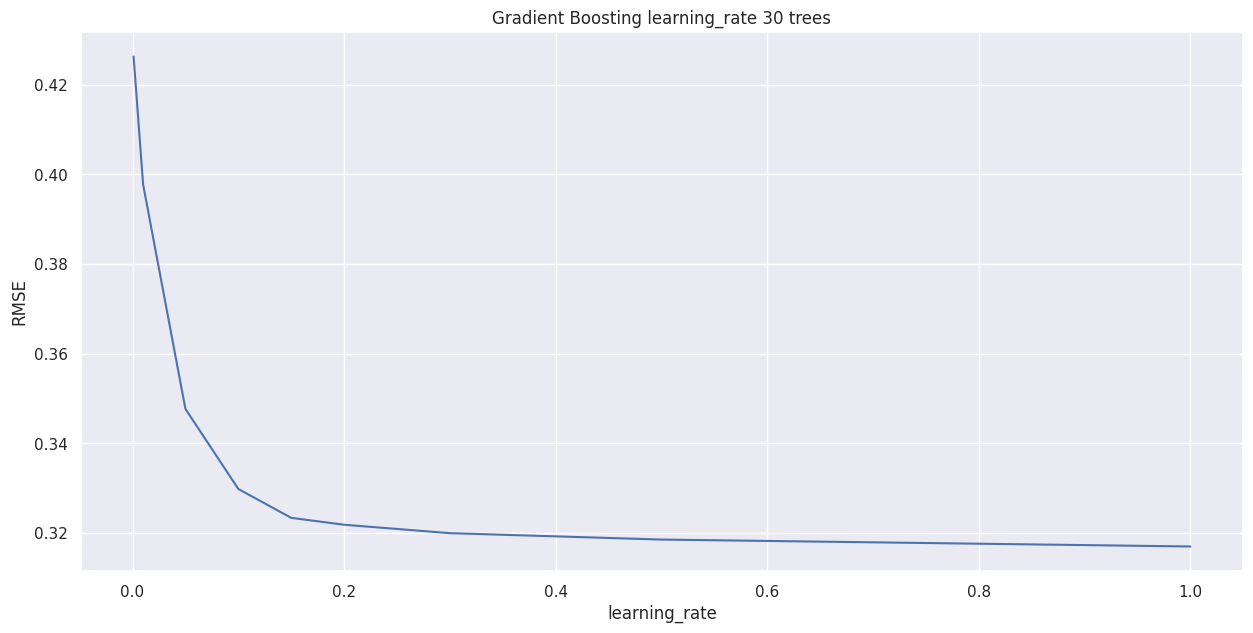

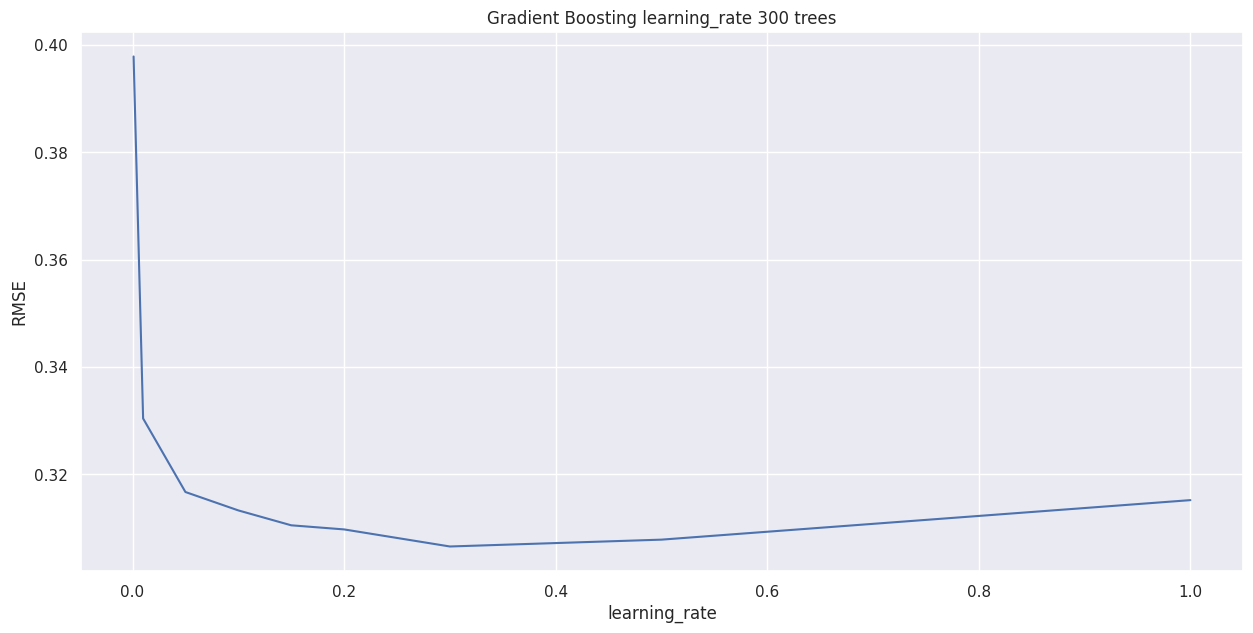

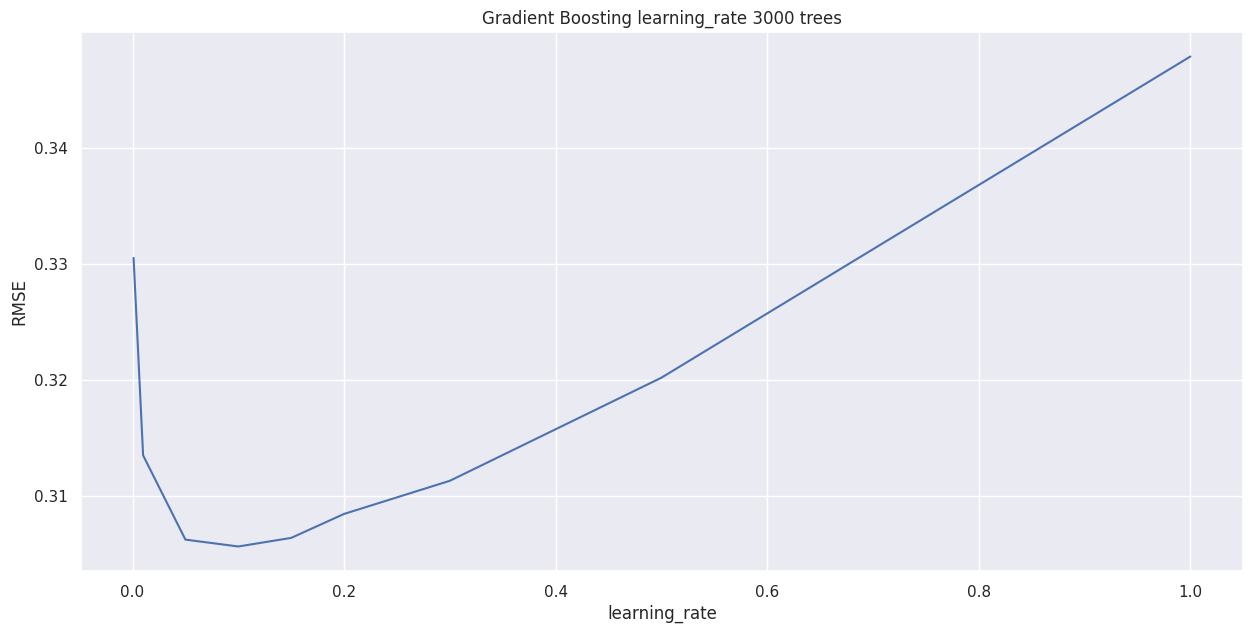

In [ ]:
from sklearn.metrics import mean_squared_error

for est in [30, 300, 3000]:
    rmse_scores = []
    for value in learning_rate_values:
        gbr = GradientBoostingRegressor(max_depth=2, n_estimators=est, 
                                        random_state=2, learning_rate=value)
        gbr.fit(X_train, y_train)
        y_pred = gbr.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        rmse_scores.append(rmse)
    plt.figure(figsize=(15,7))
    plt.plot(learning_rate_values, rmse_scores)
    plt.xlabel('learning_rate')
    plt.ylabel('RMSE')
    plt.title('Gradient Boosting learning_rate {} trees'.format(est))
    plt.show()


- 기본 학습기

In [ ]:
depths = [None, 1, 2, 3, 4]
for depth in depths:
    gbr = GradientBoostingRegressor(max_depth=depth, n_estimators=300, 
                                    random_state=2)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = MSE(y_test, y_pred)**0.5
    print('최대 깊이:', depth, ', 점수:', rmse)

In [ ]:
- 첫 번째 잔차를 계산하기 위한 초기 모델은 init_ 속성에 저장되어 있음.
- 회귀일 경우, 타깃 평균을 계산하는 DummyRegressor()이고 분류일 경우, 다수 클래스를 예측하는 DummyClassifier() 객체이다.

In [ ]:
gbr.init_

In [ ]:
len(gbr.estimators_)

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(range(1, 301), gbr.train_score_)
plt.xlabel('n_estimators')
plt.ylabel('train_score_')
plt.title('Train Score')
plt.show()

- validation_fraction
    - 일정한 수준 이상 향상되지 않으면 훈련을 종료할 수 있는 early stopping 기법을 제공
    - validation_fraction(기본값 0.1)만큼 훈련 세트에서 데이터를 덜어낸 다음 n_iter_no_change 반복 횟수 동안 검증 점수가 tol(기본값 1e-4)만큼 향상되지 않으면 훈련을 종료.

In [ ]:
depths = [None, 1, 2, 3, 4,5,6,7,8,9,10]
for depth in depths:
    gbr = GradientBoostingRegressor(max_depth=depth, n_estimators=300, 
                                    random_state=2)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = MSE(y_test, y_pred)**0.5
    print('최대 깊이:', depth, ', 점수:', rmse)

In [ ]:
depths = [None, 1, 2, 3, 4,5,6,7,8,9,10]
for depth in depths:
    gbr = GradientBoostingRegressor(max_depth=depth, n_estimators=300, 
                                    random_state=2,validation_fraction=0.2,n_iter_no_change=1)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = MSE(y_test, y_pred)**0.5
    print('최대 깊이:', depth, ', 점수:', rmse)


- subsample
    - 기본 학습기에 사용될 샘플의 비율을 지정.
    - 기본값인 1.0보다 작게 설정하면 트리를 훈련할 때, 샘플의 일부만 사용하게 됨.

In [ ]:
samples = [1, 0.9, 0.8, 0.7, 0.6, 0.5]
for sample in samples:
    gbr = GradientBoostingRegressor(max_depth=3, n_estimators=300, 
                                    subsample=sample, random_state=2)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = MSE(y_test, y_pred)**0.5
    print('subsample:', sample, ', 점수:', rmse)

- subsample이 1보다 작을 때, 이런 모델을 확률적 그레디언트 부스팅이라고 부름. 확률적이란 말은 모델에 무작위성이 주입된다는 의미.

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(range(1, 301), gbr.oob_improvement_)
plt.xlabel('n_estimators')
plt.ylabel('oob_improvement_')
plt.title('OOB Improvement')
plt.show()






dfadf# 노트북이 코랩에서 실행 중인지 체크합니다.
import sys
if 'google.colab' in sys.modules:
    !pip install -q --upgrade xgboost
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter04/bike_rentals_cleaned.csv
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter04/exoplanets.csv.zip

!unzip -o exoplanets.csv.zipdf.describe()df.describe()df.describedf.dfdffffdf

In [ ]:
params = {'subsample':[0.65, 0.7, 0.75],
          'n_estimators':[300, 500, 1000],
          'learning_rate':[0.05, 0.075, 0.1]}

# RandomizedSearchCV를 임포트합니다.
from sklearn.model_selection import RandomizedSearchCV

gbr = GradientBoostingRegressor(max_depth=3, random_state=2)


# RandomizedSearchCV를 초기화합니다.
rand_reg = RandomizedSearchCV(gbr, params, n_iter=10, 
                              scoring='neg_mean_squared_error', 
                              cv=5, n_jobs=-1, random_state=2)

# X_train와 y_train로 rand_reg를 훈련합니다.
rand_reg.fit(X_train, y_train)

# 최상의 모델을 추출합니다.
best_model = rand_reg.best_estimator_

# 최상의 매개변수를 추출합니다.
best_params = rand_reg.best_params_

# 최상의 매개변수를 출력합니다.
print("최상의 매개변수:", best_params)

# 최상의 점수를 계산합니다.
best_score = np.sqrt(-rand_reg.best_score_)

# 최상의 점수를 출력합니다.
print("훈련 점수: {:.3f}".format(best_score))

# 테스트 세트에 대한 예측을 만듭니다.
y_pred = best_model.predict(X_test)

# 평균 제곱근 오차를 계산합니다.
rmse_test = MSE(y_test, y_pred)**0.5

# 평균 제곱근 오차를 출력합니다.
print('테스트 세트 점수: {:.3f}'.format(rmse_test))

In [ ]:
gbr = GradientBoostingRegressor(max_depth=3, n_estimators=1600, 
                                subsample=0.75, learning_rate=0.02, 
                                random_state=2)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred)**0.5

### XGboost

- 그래디언트 부스팅의 고급 버전
- 잔차로부터 훈련한 트리를 추가하여 약한 학습기를 강력한 학습기로 바꾸는 것.

In [ ]:
# XGBRegressor를 임포트합니다.
from xgboost import XGBRegressor

# XGBRegressor를 초기화합니다.
xg_reg = XGBRegressor(max_depth=3, n_estimators=1600, eta=0.02, 
                      subsample=0.75, random_state=2)

# 훈련 세트에서 xg_reg를 훈련합니다.
xg_reg.fit(X_train, y_train)

# 테스트 세트에 대한 예측을 만듭니다.
y_pred = xg_reg.predict(X_test)

# 평균 제곱근 오차를 계산합니다.
MSE(y_test, y_pred)**0.5

### 빅데이터 다루기 : Gradient Boosting VS Xgboost

- 외계 행성 데이터셋 전처리(https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data)
    - 별의 생명 주기 동안에 빛의 밝기를 기록한 것.
    - label : 외계 행성을 가지고 있으면 2, 아니면 1

In [ ]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import sys
if 'google.colab' in sys.modules:
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter02/heart_disease.csv

In [1]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import sys
if 'google.colab' in sys.modules:
    !pip install -q --upgrade xgboost
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter04/bike_rentals_cleaned.csv
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter04/exoplanets.csv.zip

!unzip -o exoplanets.csv.zip

Archive:  exoplanets.csv.zip
  inflating: exoplanets.csv          


In [2]:
import pandas as pd
df = pd.read_csv('exoplanets.csv')
df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [3]:
df.describe()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
count,5087.000000,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,...,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.000000
mean,1.007273,1.445054e+02,1.285778e+02,1.471348e+02,1.561512e+02,1.561477e+02,1.469646e+02,1.168380e+02,1.144983e+02,1.228639e+02,...,3.485578e+02,4.956476e+02,6.711211e+02,7.468790e+02,6.937372e+02,6.553031e+02,-494.784966,-544.594264,-440.239100,-300.536399
std,0.084982,2.150669e+04,2.179717e+04,2.191309e+04,2.223366e+04,2.308448e+04,2.410567e+04,2.414109e+04,2.290691e+04,2.102681e+04,...,2.864786e+04,3.551876e+04,4.349963e+04,4.981375e+04,5.087103e+04,5.339979e+04,17844.469520,17722.339334,16273.406292,14459.795577
min,1.000000,-2.278563e+05,-3.154408e+05,-2.840018e+05,-2.340069e+05,-4.231956e+05,-5.975521e+05,-6.724046e+05,-5.790136e+05,-3.973882e+05,...,-3.240480e+05,-3.045540e+05,-2.933140e+05,-2.838420e+05,-3.288214e+05,-5.028894e+05,-775322.000000,-732006.000000,-700992.000000,-643170.000000
25%,1.000000,-4.234000e+01,-3.952000e+01,-3.850500e+01,-3.505000e+01,-3.195500e+01,-3.338000e+01,-2.813000e+01,-2.784000e+01,-2.683500e+01,...,-1.760000e+01,-1.948500e+01,-1.757000e+01,-2.076000e+01,-2.226000e+01,-2.440500e+01,-26.760000,-24.065000,-21.135000,-19.820000
50%,1.000000,-7.100000e-01,-8.900000e-01,-7.400000e-01,-4.000000e-01,-6.100000e-01,-1.030000e+00,-8.700000e-01,-6.600000e-01,-5.600000e-01,...,2.600000e+00,2.680000e+00,3.050000e+00,3.590000e+00,3.230000e+00,3.500000e+00,-0.680000,0.360000,0.900000,1.430000
75%,1.000000,4.825500e+01,4.428500e+01,4.232500e+01,3.976500e+01,3.975000e+01,3.514000e+01,3.406000e+01,3.170000e+01,3.045500e+01,...,2.211000e+01,2.235000e+01,2.639500e+01,2.909000e+01,2.780000e+01,3.085500e+01,18.175000,18.770000,19.465000,20.280000
max,2.000000,1.439240e+06,1.453319e+06,1.468429e+06,1.495750e+06,1.510937e+06,1.508152e+06,1.465743e+06,1.416827e+06,1.342888e+06,...,1.779338e+06,2.379227e+06,2.992070e+06,3.434973e+06,3.481220e+06,3.616292e+06,288607.500000,215972.000000,207590.000000,211302.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB


In [5]:
df.isnull().sum()

LABEL        0
FLUX.1       0
FLUX.2       0
FLUX.3       0
FLUX.4       0
            ..
FLUX.3193    0
FLUX.3194    0
FLUX.3195    0
FLUX.3196    0
FLUX.3197    0
Length: 3198, dtype: int64

In [6]:
df.iloc[:,0]

0       2
1       2
2       2
3       2
4       2
       ..
5082    1
5083    1
5084    1
5085    1
5086    1
Name: LABEL, Length: 5087, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
# 데이터를 X와 y로 나눕니다.
X = df.iloc[:,1:]
y = df.iloc[:,0] - 1 # 0과 1로 만들기 위해.

# 훈련 세트와 테스트 세트로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

- 그레이디언트 부스팅 분류 모델 만들기

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
# XGBClassifier를 임포트합니다.
from xgboost import XGBClassifier

# accuracy_score를 임포트합니다.
from sklearn.metrics import accuracy_score

- 시간 측정

In [9]:
import time
start = time.time()

df.info()

end = time.time()
elapsed = end - start

print('\n실행 시간: ' + str(elapsed) + ' 초')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB

실행 시간: 0.06363129615783691 초


- 1번만 시간을 측정하고 싶다면 %time을 이용하는 것이 편리. 
- 함수의 실행시간을 세부적으로 알고 싶다면 %prun을 이용하면 좋다.

In [10]:
%timeit -n 100 -r 3 sum(np.square(range(10000))) # -n : number / -r :repeat

3.24 ms ± 83 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [11]:
%%timeit -n 100 -r 3 
summing = 0
for i in range(10000):
    summing += i**2

4.65 ms ± 968 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


- 속도 비교

In [12]:
start = time.time()

gbr = GradientBoostingClassifier(n_estimators=100, 
                                 max_depth=2, random_state=2)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('점수: ' + str(score))

end = time.time()
elapsed = end - start

print('실행 시간: ' + str(elapsed) + ' 초')

점수: 0.9874213836477987
실행 시간: 371.55844378471375 초


In [13]:
start = time.time()

# XGBRegressor를 초기화합니다.
xg_reg = XGBClassifier(n_estimators=100, max_depth=2)

# 훈련 세트에서 xg_reg를 훈련합니다.
xg_reg.fit(X_train, y_train)

# 테스트 세트에 대한 예측을 만듭니다.
y_pred = xg_reg.predict(X_test)

score = accuracy_score(y_pred, y_test)

print('점수: ' + str(score))

end = time.time()
elapsed = end - start

print('실행 시간: ' + str(elapsed) + ' 초')

점수: 0.9913522012578616
실행 시간: 92.70509266853333 초


- 근사 분할 탐색 알고리즘
    - 최적의 분할을 찾는 것이 결정트리의 목표이다.
    - greedy algorithm은 매 단계에서 최상의 분할을 선택하고, 이전 노드를 돌아보지 않음. 

- 새로운 근사 분할 탐색 알고리즘
    - 분할 탐색 알고리즘은 데이터를 나누는 퍼센트인 분위수(quantile)을 사용하여 후보 분할을 제안
    - 전역적 제안(global proposal)에서는 동일한 분위수가 전체 훈련에 사용됨.
    - 지역 제안(local proposal)에서는 각 분할마다 새로운 분위수를 제안.

- Quantile sketch algorithm
    - 가중치가 균일한 데이터셋에서 잘 동작함.
    - xgboost는 이론적으로 보장된 병합과 가지치기를 기반으로 한 새로운 가중 qunatile sketch algorithm 을 사용.

- 희소성 고려 분할 탐색
    - 희소한 데이터는 대부분의 원소가 0이거나 null인 데이터.
    - 희소행렬은 0이 아니거나 널이 아닌 데이터 포인트만 저장하여 공간을 절약
    - 희소성 고려 분할은 탐색할 때 희소한 행렬에서 xgboost가 더 빠르다는 것을 의미.

- 병렬 컴퓨팅
    - 여러 개의 계산 유닛이 동시에 동일한 문제에 대해 작업하는 것.
    - 데이터를 block이란 단위로 정렬하고 압축함. 이런 블록은 여러 대의 머신이나 외부 메모리에 분산될 수 있음.
    - 분할 탐색 알고리즘은 블록의 장점을 사용해 분위수 탐색을 빠르게 수행함.

- 캐쉬 고려 접근
    - 컴퓨터의 데이터는 캐시와 메인 메모리에 나뉘어 있습니다. 가장 빈번하게 사용하는 캐시는 고속 메모리를 사용함.

    - 자주 사용하지 않은 데이터는 저속 메모리에 저장됨. 
    - 참고) https://gist.github.com/jboner/2841832

    - gradient 통계의 경우 xgboost는 캐시를 고려한 프리페칭(prefetching)을 사용함.
    - 내부 버퍼를 할당하고 gradient 통계를 가져와 미니배치 방식으로 누적을 수행.
    - 프리페칭은 읽기/쓰기 의존성을 느슨하게 만들고 많은 샘플을 가진 데이터셋에서 실행 부하를 약 50% 절감함.

- 블록 압축과 샤딩
    - 블록 압축은 열을 압축하여 계산 비용이 많이 드는 디스크 읽기에 도움 됨.
    - 블록 샤딩은 번갈아 가며 여러 디스크로 데이터를 샤딩하기 때문에, 데이터를 읽는 시간을 줄여줌.

- XGBoost 모델 만들기

In [14]:
import pandas as pd
import numpy as np
from sklearn import datasets
iris = datasets.load_iris()

- np.c_ : Translates slice objects to concatenation along the second axis.(https://numpy.org/doc/stable/reference/generated/numpy.c_.html)

- 참고 : https://rfriend.tistory.com/352

In [15]:
df = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                  columns=iris['feature_names'] + ['target'])

In [16]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


- Xgboost의 하이퍼 파라미터는 다양한 하이퍼 파라미터가 존재함.
    - 일반 파라미터 : 부스팅을 수행할 때 트리를 사용할지, 선형 모델을 사용할지 등을 고른다.
        -  booster[기본값=gbtree]
            - 어떤 부스트 구조를 쓸지 결정하는 것.
            - 의사결정기반 모형(gbtree), 선형 모델(gblinear),dart가 있다.
        -  n_jobs
            - xgboost를 실행하는데 사용되는 병렬 스레드 수
        -  verbosity[기본값=1]
            - 유효한 값은 0(무음), 1(경고), 2(정보), 3(디버그)
    - 부스트 파라미터 : 선택한 부스터에 따라서 적용할 수 있는 파라미터 종류가 다르다.
        - gbtree Booster의 파라미터
            - learning_rate['기본값':0.3]
                - learning_rate값, learning_rate가 높을수록 과적합 하기 쉽다.
            - n_estimators : 생성할 weak learner의 수
                - learning_rate가 낮을 땐, n_estimators를 높여야 과적합이 방지 됨.
            - max_depth[기본값 : 6]
                - 트리의 maximum depth이다.
                - 적절한 값이 제시되어야 하고 보통 3~10 사이 값이 적용됨.
                - max_depth가 높을수록 모델의 복잡도가 커져 과적합 하기 쉽다.
            - min_child_weight [기본값 1]
                - 관측치에 대한 가중치 합의 최소를 말함.
                - 값이 높을수록 과적합이 방지 됨.
            - gamma[기본값:0]
                - leaf node의 추가분할을 결정할 최소손실 감소값.
                - 해당값보다 손실이 크게 감소할 때 분리한다.
                - 값이 높을수록 과적합이 방지됨.
            - subsample[기본값:1]
                - weak learner가 학습에 사용하는 데이터 샘플링 비율이다. / 보통 0.5 ~ 1이 사용됨.
                - 값이 낮을수록 과적합이 방지 됨.
            - colsample_bytree[기본값:1]
                - 각 tree 별 사용된 feature의 percentage 이다. / 보통 : 0.5 ~ 1이 사용됨.
                - 값이 낮을수록 과적합이 방지 됨.
            - lambda [기본값=1, 별칭 : reg_lambda]
                - 가중치에 대한 L2 Regulization 적용 값이다.
                - 피처 개수가 많을 때 적용을 검토한다.
                - 이 값이 클수록 과적합 감소 효과가 있다.
            - alpha [기본값 = 0, 별칭 reg_alpha]
                - 가중치에 대한 L1 Regulization 적용 값이다.
                - 피쳐 개수가 많을 때, 적용을 검토한다.
                - 이 값이 클수록 과적합 감소 효과가 있다.

    - 학습 과정 파라미터 : 학습 시나리오를 결정한다.
        - object [기본값 : reg = squared error]
            - reg : squared error
                - 제곱 손실이 있는 회귀
            - binary : logistic(binary-logistic classification)
                - 이항 분류 문제 로지스틱 회귀 모형으로 반환값이 클래스가 아니라 예측 확률
            - multi : softmax
                - 다항 분류 문제의 경우 Softmax를 사용해서 분류한느데 반환되는 값이 예측확률이 아니라 클래스이다. 또한 num_class도 지정해야 한다.
            - multi : softprob
                - 각 클래스에 범주에 속하는 예측 확률을 반환한다.
            - count : poisson(count data poison regression) 등 다양함.

**eval_metric**

- 모델의 평가 함수를 조정하는 함수다.
- 설정한 objective 별로 기본설정값이 지정되어 있다.
- rmse: root mean square error
- mae: mean absolute error
- logloss: negative log-likelihood
- error: Binary classification error rate (0.5 threshold)    
- merror: Multiclass classification error rate
- mlogloss: Multiclass logloss
- auc: Area under the curve
- map (mean average precision)등, 해당 데이터의 특성에 맞게 평가 함수를 조정한다.
- seed [ 기본값 : 0 ]
    - 재현가능하도록 난수를 고정시킴.

**민감하게 조정해야하는 것**
- booster 모양
- eval_metric(평가함수) / objective(목적함수)
- eta 
- L1 form (L1 레귤러라이제이션 폼이 L2보다 아웃라이어에 민감하다.)
- L2 form

**과적합 방지를 위해 조정해야하는 것**

- learning rate 낮추기 → n_estimators은 높여야함
- max_depth 낮추기
- min_child_weight 높이기
- gamma 높이기
- subsample, colsample_bytree 낮추기

- XGBoost분류 모델

In [17]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

- booster = 'gbtree' : 어떤 부스트 구조를 쓸지 결정하는 것. / 의사결정기반 모형(gbtree)
- objective = 'multi::softprob' / 각 클래스에 범주에 속하는 예측 확률을 반환.
- max_depth=6 : max_depth는 트리의 깊이를 지정.
- learning_rate  = 0.1 / xgboost에서는  eta라고 부름. 지정된 비율로 각 트리의 가중치를 감소시켜 분산을 억제
- n_estimations=100 / 부스팅에 포함할 트리 개수 / learning_rate를 줄이고 이 값을 늘리면 더 높은 성능을 얻을 수 있음.

In [18]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(iris['data'],iris['target'],random_state=2)

In [19]:
xgb = XGBClassifier(booster='gbtree', objective='multi:softprob', 
                    max_depth=6, learning_rate=0.1, n_estimators=100, 
                    n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('점수: ' + str(score))

점수: 0.9736842105263158


- accuracy_score() 함수 대신 score() 메서드를 사용할 수 있습니다.

In [20]:
xgb.score(X_test, y_test)

0.9736842105263158

- XGBoost의 기본 파이썬 API를 사용하는 경우 부스터(Booster) 객체의 predict() 메서드는 multi:softprob일 때 확률을 반환하고 multi:softmax일 때 클래스 레이블을 반환합니다

- 주로 사이킷런 API로 XGBoost 모델을 만듭니다. 사이킷런 XGBoost API는 2019년에 릴리즈 됨.
- XGBoost 프레임워크의 장점을 사용하려면 넘파이 배열을 DMatrix로 바꿔야 함.






- 참고 : https://stackoverflow.com/questions/37943403/difference-between-original-xgboost-learning-api-and-sklearn-xgbclassifier-sc

In [21]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test[:5])

param = {'objective': 'multi:softprob', 'num_class': 3}
bstr = xgb.train(param, dtrain, 10)
bstr.predict(dtest)


array([[0.9486482 , 0.02711029, 0.02424142],
       [0.9486482 , 0.02711029, 0.02424142],
       [0.02841366, 0.05416913, 0.9174172 ],
       [0.9486482 , 0.02711029, 0.02424142],
       [0.9486482 , 0.02711029, 0.02424142]], dtype=float32)

In [22]:
param = {'objective': 'multi:softmax', 'num_class': 3}
bstr = xgb.train(param, dtrain, 10)
bstr.predict(dtest)

array([0., 0., 2., 0., 0.], dtype=float32)

- 당뇨병 데이터셋

In [23]:
X, y = datasets.load_diabetes(return_X_y=True)

- XGBoost 회귀 모델(교차 검증)

In [24]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror', 
                   max_depth=6, learning_rate=0.1, n_estimators=100, 
                   n_jobs=-1)

scores = cross_val_score(xgb, X, y, 
                         scoring='neg_mean_squared_error', cv=5)

# 평가 점수의 제곱근을 계산한합니다.
rmse = np.sqrt(-scores)

# RMSE를 출력합니다.
print('RMSE:', np.round(rmse, 3))

# 평균 점수를 출력합니다.
print('RMSE 평균: %0.3f' % (rmse.mean()))

RMSE: [63.011 59.705 64.538 63.706 64.588]
RMSE 평균: 63.109


In [25]:
pd.DataFrame(y).describe()

,0
count,442.000000
mean,152.133484
std,77.093005
min,25.000000
25%,87.000000
50%,140.500000
75%,211.500000
max,346.000000


- 힉스 보손은 신의 입자로 알려져 있음.
- 피터 힉스가 1964년 이론화한 힉스 보손은 입자가 질량을 가지는 이유를 설명하기 위해 소개되었음
- 양성자를 매우 빠른 속도로 서로 충돌시키고 그 결과를 관찰함으로써 힉스 보손을 발견함. 관측 데이터는 ATLAS 검출기로 얻습니다. 이 검출기는 초당 수억 건의 양성자 충돌로 인한 데이터를 기록함.

- 힉스 보손 발견 후 다음 단계는 붕괴의 특성을 정확하게 측정하는 것이다.
- 배경 잡음으로 돌러싸인 ATLAS 실험 데이터에서 힉스 보손이 두 개의 타우 입자로 붕괴하는 것을 발견한다.

- 대회 참고 : https://www.kaggle.com/c/higgs-boson

In [27]:
import sys
if 'google.colab' in sys.modules:
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter05/atlas-higgs-challenge-2014-v2.csv.gz

In [28]:
df = pd.read_csv('atlas-higgs-challenge-2014-v2.csv.gz', nrows=250000, compression='gzip')
df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


- Kaggleset과 kaggleweight 열을 볼 수 있음.
- 캐글 데이터셋은 더 작았기 때문에 캐글은 kaggleWeight라는 가중치 열의 숫자가 달랐음.
- KaggleSet열의 t값은 캐글 데이터셋의 훈련 세트라는 의미.
- KaggleSet과 KaggleWeight 두열은 캐글 데이터셋에서 사용할 정보를 포함한 열.
- 캐글 훈련 데이터와 같게 만들기 위해 KaggleSet과 Weight 열을 삭제하고 KaggleWeight를 Weight로 바꾸고 label 열을 마지막으로 옮깁니다.

In [29]:
del df['Weight']
del df['KaggleSet']
df = df.rename(columns={"KaggleWeight": "Weight"})

In [30]:
df

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label,Weight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,s,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,b,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,b,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,b,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,b,6.245333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,349995,-999.000,71.989,36.548,5.042,-999.00,-999.000,-999.000,1.392,5.042,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,b,4.505083
249996,349996,-999.000,58.179,68.083,22.439,-999.00,-999.000,-999.000,2.585,22.439,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,b,2.497259
249997,349997,105.457,60.526,75.839,39.757,-999.00,-999.000,-999.000,2.390,22.183,...,1,41.992,1.800,-0.166,-999.000,-999.00,-999.000,41.992,s,0.018636
249998,349998,94.951,19.362,68.812,13.504,-999.00,-999.000,-999.000,3.365,13.504,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,b,1.681611


- Label 열을 마지막으로 옮기는 한 가지 방법은 이 열을 변수에 저장하고 원본 데이터프레임에서 삭제한 다음 다시 새로운 열을 추가하는 것.

In [31]:
label_col = df['Label']
del df['Label']
df['Label'] = label_col

- 판다스는 파이썬의 del 키워드보다 drop() 메서드를 권장함.
- label 열을 마지막에 놓는 더 나은 방법은 먼저 Label을 삭제하고, 그 다음 assign() 메서드를 메서드로 Label 열을 새로운 열로 추가하는 것.

In [32]:
df_h = pd.read_csv('atlas-higgs-challenge-2014-v2.csv.gz', nrows=250000, compression='gzip')

- drop() 메서드는 이 세개의 열이 삭제된 데이터프레임을 반환함.
- 이 데이터프레임에서 assign() 메서드를 이어서 호출할 수 있음. assign() 메서드에서는 추가할 열의 이름을 키워드 매개변수로 사용함.

In [34]:
df_new = df_h.drop(['Weight', 'KaggleSet', 'Label'], axis=1).assign(Label=df_h['Label'])
df_new = df_new.rename(columns={'KaggleWeight': 'Weight'})

In [35]:
df_new

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,349995,-999.000,71.989,36.548,5.042,-999.00,-999.000,-999.000,1.392,5.042,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,4.505083,b
249996,349996,-999.000,58.179,68.083,22.439,-999.00,-999.000,-999.000,2.585,22.439,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,2.497259,b
249997,349997,105.457,60.526,75.839,39.757,-999.00,-999.000,-999.000,2.390,22.183,...,1,41.992,1.800,-0.166,-999.000,-999.00,-999.000,41.992,0.018636,s
249998,349998,94.951,19.362,68.812,13.504,-999.00,-999.000,-999.000,3.365,13.504,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.681611,b


- column index 0 : EventID - 머신러닝 모델과 관련이 없음.
- column index 1~30 : LHC충돌에서 얻은 물리량.
- column index 31 : weight : 이 열은 스케일 조정에 사용됨.
- column index 32 : 타깃 열 / 신호는 s, 배경 잡음은 b로 레이블되어 있음. 훈련 데이터는 실제 데이터에서 시뮬레이션으로 생성했기 때문에, 원래 보다 더 많은 신호가 있음

In [36]:
df_new['Label'].replace(('s', 'b'), (1, 0), inplace=True)

In [37]:
X = df_new.iloc[:,1:31]
y = df_new.iloc[:,-1]

- 열을 선택하는 다른 방법
    -  label을 뒤로 보낸 이유는 iloc 메서드를 사용해 인덱스로 특성과 타깃 열을 쉽게 나눌 수 있기 때문이다. 하지만 loc 메서드를 사용하면 label 열을 옮기지 않고도 열 이름이나 불리언 배열을 사용해 특성과 타깃을 편리하게 나눌 수 있습니다.

In [38]:
X_new = df_new.loc[:, ~df_new.columns.isin(['EventId','Weight','Label'])]
y_new = df_new.loc[:, 'Label']

- df_new.columns.isin() 메서드는 전달된 열 이름이 있으면 해당 열 위치에 True, 그렇지 않으면 False을 반환.

In [39]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_new = le.fit_transform(df_new['Label'])
y_new

array([1, 0, 0, ..., 1, 0, 0])

- 측정 지표
    - 대회 metric(https://www.kaggle.com/c/higgs-boson)

- XGBoost의 사이킷런 API는  fit() 메서드의 eval_metric 매개변수에 측정 지표를 지정할 수 있다.
- 이진 분류일 경우 'logloss', 다중 분류일 경우 'mlogloss'
- eval_metric 매개변수를 지정할 경우, eval_set 매개변수에 평가할 데이터셋을 (특성,타깃) 튜플의 리스트로 전달해야합니다.

In [40]:
xgb = XGBClassifier(n_estimators=5)
xgb.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mlogloss')

[0]	validation_0-mlogloss:0.73655	validation_1-mlogloss:0.74850
[1]	validation_0-mlogloss:0.52525	validation_1-mlogloss:0.54465
[2]	validation_0-mlogloss:0.38855	validation_1-mlogloss:0.41754
[3]	validation_0-mlogloss:0.29493	validation_1-mlogloss:0.33279
[4]	validation_0-mlogloss:0.22880	validation_1-mlogloss:0.27454


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=5, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [41]:
xgb.evals_result()

{'validation_0': OrderedDict([('mlogloss',
               [0.7365548280732972,
                0.5252466491822686,
                0.3885539788752794,
                0.2949308359197208,
                0.22880319266447])]),
 'validation_1': OrderedDict([('mlogloss',
               [0.7485030999309138,
                0.5446543285721227,
                0.4175380499739396,
                0.33279044534030716,
                0.2745441574799387])])}

- 가중치
    - 힉스 보손 데이터 셋의 타깃인 s(신호)와 b(배경 잡음)에 대해서 생각해보자.
    - 실제로 b가 s보다 훨씬 많아서, 신호는 배경 잡음 사이에서 드물게 나타남.
    - ex) 신호가 배경잡음보다 1,000배 드물게 나타난다고 가정하면 s=1, b=1/1000으로 주면 이런 불균형을 보상할 수 있음.
    - 모두 더하면 2012년 데이터 수집 당시 기대되는 신호와 배경 잡음의 횟수를 제공
    - 실제와 같은 예측을 만들기 위해 가중치가 필요함.
    - 그렇지 않으면 너무 많은 s(신호) 이벤트를 예측할 것이다.
    - test_set_size :550,000

In [42]:
df_new['test_Weight'] = df_new['Weight'] * 550000 / len(y)

In [43]:
s = np.sum(df_new[df_new['Label']==1]['test_Weight'])
b = np.sum(df_new[df_new['Label']==0]['test_Weight'])

In [44]:
b/s

593.9401931492318

- 가중치는 신호와 배경 잡음의 기대 횟수를 나타냄.
- 테스트 데이터에 맞게 가중치를 조정한 다음 배경 잡음의 가중치 합을 신호의 가중치 합으로 나눔.

- 대회 당시 xgboost는 나온지 얼마 안되었고, 사이킷런의 API는 아직 없었습니다.
- 많은 자료들이 사이킷런이 아닌 경우가 있습니다.

- 누락된 값과 가중치를 지정한 DMatrix로 XGboost 모델을 초기화합니다.
- 사이킷런 전에는 모든 XGboost모델은 DMatrix로 초기화를 하엿습니다.
- 사이킷런 API는 입력 데이터를 자동으로 DMatrix로 변환합니다.
- DMatrix는 속도를 위해 XGboost가 최적화한 희소 행렬
- 문서에 따르면 -999.0는 누락된 값을 의미.
- XGboost에서는 missing 매개변수로 누락된 값을 알릴 수 있음.

In [45]:
import xgboost as xgb

# 넘파이 배열로 xgboost.DMatrix 만들기. -999.0는 누락된 값으로 다룹니다.
xgmat = xgb.DMatrix(X, y, missing = -999.0, weight=df_new['test_Weight'])

# xgboost 파라미터 설정
param = {}
# 랭킹만 필요하기 때문에 로지스틱 함수를 적용하기 전의 출력을 사용합니다.
#모델이 시그모이드 함수를 적용하기 전의 점수(로짓,logit)을 최적화 한다는 의미.
# 이 대회에서는 확률이 아니라 랭킹을 제출하기 때문에 로짓으로도 충분함.
param['objective'] = 'binary:logitraw'
# 양성 샘플의 가중치를 조정합니다. -> 불균형을 보상.-> 테스트셋에서 좋은 성능을 내는데 도움.
param['scale_pos_weight'] = b/s
param['eta'] = 0.1
param['max_depth'] = 6
param['eval_metric'] = 'auc' # AUC : 진짜 양성 대 가짜 양성 곡선 아래 면적으로 1이면 완벽한 값.
#불균형한 데이터셋에 잘 안맞기 때문에, 종종 AUC가 낫습니다.

# ams 지표를 추가합니다.
#ams@0.15 -> 상위 15%를 신호로 판단한다는 의미.
plst = list(param.items())+[('eval_metric', 'ams@0.15')]

#트리가 추가됨에 따라 점수를 볼 수 있도록 분류 모델와
#'train'을 포함하는 watchlist를 만듦.
watchlist = [(xgmat,'train')]

# 120개 트리 부스팅
num_round = 120

print('데이터 로딩 완료, 트리 부스팅 시작')
bst = xgb.train(plst, xgmat, num_round, watchlist)
#save_model()메서드를 사용해 모델을 저장
bst.save_model('higgs.model')
print('훈련 종료')

데이터 로딩 완료, 트리 부스팅 시작


/usr/local/lib/python3.9/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-auc:0.91091	train-ams@0.15:3.71929
[1]	train-auc:0.91535	train-ams@0.15:3.99108
[2]	train-auc:0.91800	train-ams@0.15:4.11401
[3]	train-auc:0.91953	train-ams@0.15:4.24602
[4]	train-auc:0.92050	train-ams@0.15:4.24262
[5]	train-auc:0.92133	train-ams@0.15:4.25282
[6]	train-auc:0.92226	train-ams@0.15:4.33230
[7]	train-auc:0.92338	train-ams@0.15:4.35821
[8]	train-auc:0.92389	train-ams@0.15:4.37353
[9]	train-auc:0.92427	train-ams@0.15:4.36459
[10]	train-auc:0.92484	train-ams@0.15:4.36423
[11]	train-auc:0.92543	train-ams@0.15:4.40963
[12]	train-auc:0.92584	train-ams@0.15:4.41484
[13]	train-auc:0.92645	train-ams@0.15:4.46174
[14]	train-auc:0.92688	train-ams@0.15:4.43823
[15]	train-auc:0.92738	train-ams@0.15:4.47194
[16]	train-auc:0.92805	train-ams@0.15:4.52048
[17]	train-auc:0.92848	train-ams@0.15:4.57089
[18]	train-auc:0.92903	train-ams@0.15:4.60307
[19]	train-auc:0.92937	train-ams@0.15:4.65550
[20]	train-auc:0.92989	train-ams@0.15:4.69064
[21]	train-auc:0.93018	train-ams@0.15:4.7137

- 사이킷런 API로 구현하기

In [46]:
clf = XGBClassifier(n_estimators=120, learning_rate=0.1, missing=-999.0, 
                    scale_pos_weight=b/s)

clf.fit(X, y, sample_weight=df_new['test_Weight'], 
        eval_set=[(X, y)], eval_metric=['auc', 'ams@0.15'],
        sample_weight_eval_set=[df_new['test_Weight']])

clf.save_model('higgs-sklearn.model')

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.91091	validation_0-ams@0.15:3.71474
[1]	validation_0-auc:0.91531	validation_0-ams@0.15:3.98386
[2]	validation_0-auc:0.91774	validation_0-ams@0.15:4.07945
[3]	validation_0-auc:0.91935	validation_0-ams@0.15:4.20276
[4]	validation_0-auc:0.92014	validation_0-ams@0.15:4.13682
[5]	validation_0-auc:0.92102	validation_0-ams@0.15:4.17654
[6]	validation_0-auc:0.92194	validation_0-ams@0.15:4.26270
[7]	validation_0-auc:0.92234	validation_0-ams@0.15:4.26319
[8]	validation_0-auc:0.92333	validation_0-ams@0.15:4.32849
[9]	validation_0-auc:0.92419	validation_0-ams@0.15:4.38122
[10]	validation_0-auc:0.92474	validation_0-ams@0.15:4.39352
[11]	validation_0-auc:0.92532	validation_0-ams@0.15:4.40786
[12]	validation_0-auc:0.92592	validation_0-ams@0.15:4.44646
[13]	validation_0-auc:0.92633	validation_0-ams@0.15:4.44902
[14]	validation_0-auc:0.92696	validation_0-ams@0.15:4.48816
[15]	validation_0-auc:0.92743	validation_0-ams@0.15:4.51683
[16]	validation_0-auc:0.92808	validation_0-ams@0.1

In [ ]:
clf.score(X, y)

# 6장. XGBoost hyperparameters

- 심장질환 데이터셋

In [2]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import sys
if 'google.colab' in sys.modules:
    !pip install -q --upgrade xgboost
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter06/heart_disease.csv

- target : binary value(1: 심장 질환 있는 사람 / 0:그렇지 않다)
- age : 나이
- sex : 성별(1=남성,0=여성)
- cp : 가슴 통증(chest pain) (1=전형적인 협심증, 2= 비전형적인 협심증, 3=협심증이 아닌 통증, 4=무증상)
- trestbps : 안정혈압 (입원시 mmHg)
- chol : 혈청 콜레스테롤(serum cholesterol)(mg/dl)
- fbs : 공복혈당 > 120 mg/dl (1=True, 0=False)
- restecg : 심전도 결과(0=정상, 1=ST-T파 이상)(T파 반전 및 또는 0.05mV 이상의 ST 상승 또는 감소), 2 = Estes 기준에 의해 좌심실 비대증 가능성 또는 유력
- thalach : 최대 심장 박동수
- exang : 운동으로 인한 협심증(1=yes, 2=no)
- oldpeak : 휴식 대비 운동으로 인한 ST 감소
- slope : 최대 운동 ST 세그먼트 기울기(1=상승 기울기, 2=수평,3=하강 기울기)
- ca : 형광 투시로 착색된 주요 혈관(0-3)
- thal : 탈륨 스트레스 테스트(3=정상, 6=고정 결합, 7=가역적 결함)

In [1]:
# 경고 끄기
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
xgb.set_config(verbosity=0)
#- verbose
#    - 실행 과정 출력 여부(=0 기본값, 대규모 모델을 만들 때는 verbose=1로 선언함)

In [3]:
import pandas as pd
df = pd.read_csv('heart_disease.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


- XGBClassifier

In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [6]:
# 데이터를 X와 y로 나눕니다.
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [7]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic')

In [8]:
# cross_val_score를 임포트합니다.
from sklearn.model_selection import cross_val_score

# numpy를 임포트합니다.
import numpy as np

# 교차 검증 점수를 구합니다.
scores = cross_val_score(model, X, y, cv=5)

# 정확도를 출력합니다.
print('정확도:', np.round(scores, 2))

# 정확도 평균을 출력합니다.
print('정확도 평균: %0.2f' % (scores.mean()))

정확도: [0.84 0.85 0.82 0.8  0.77]
정확도 평균: 0.81


- booster = 'gbtree' : 어떤 부스트 구조를 쓸지 결정하는 것. / 의사결정기반 모형(gbtree)
- objective = 'multi::logistic' / 이진 분류의 기본 손실 함수

### StratifiedKFold
- 각 fold의 타깃 레이블의 비율을 동일하게 만듦.

- 참고 : https://amueller.github.io/aml/04-model-evaluation/1-data-splitting-strategies.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

![image.png](https://i.imgur.com/lClmYp7.jpg)

- cross_val_score()와 GridSearchCV, RandomizedSearchCV에서 분류 모델을 받으면 기본적으로 StratifiedKFold(n_splits=cv) 객체를 사용하기 때문에, cv 매개변수에 폴드 수만 지정하면 됨.

- Fold를 나누기 전에 데이터를 섞기 위해 StratifiedKFold의 shuffle 매개변수(기본값 False)를 True로 지정하여 직접 StratifiedKFold의 객체를 만들어 cv 매개변수에 전달을 함.

In [10]:
# StratifiedKFold를 임포트합니다.
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

In [11]:
print('전체 데이터의 클래스 분포:', np.bincount(y))
print()

for split_no, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
    print('{}번째 훈련 폴드:'.format(split_no+1), np.bincount(y[train_idx]))
    print('{}번째 검증 폴드:'.format(split_no+1), np.bincount(y[test_idx]))

    print()

전체 데이터의 클래스 분포: [138 165]

1번째 훈련 폴드: [110 132]
1번째 검증 폴드: [28 33]

2번째 훈련 폴드: [110 132]
2번째 검증 폴드: [28 33]

3번째 훈련 폴드: [110 132]
3번째 검증 폴드: [28 33]

4번째 훈련 폴드: [111 132]
4번째 검증 폴드: [27 33]

5번째 훈련 폴드: [111 132]
5번째 검증 폴드: [27 33]



- 기준 모델

In [12]:
# 교차 검증 점수를 계산합니다.
scores = cross_val_score(model, X, y, cv=kfold)

# 정확도를 출력합니다.
print('정확도:', np.round(scores, 2))

# 정확도 평균을 출력합니다.
print('정확도 평균: %0.2f' % (scores.mean()))

정확도: [0.72 0.82 0.75 0.8  0.82]
정확도 평균: 0.78


- GridSearch와 RandomizedSearchCV

In [13]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

In [14]:
def grid_search(params, random=False):

  xgb = XGBClassifier(booster ='gbtree', objective='binary:logistic',
                      random_state=2, verbosity=0, use_label_encoder=False)
  
  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

  if random:
    grid = RandomizedSearchCV(xgb,params, cv=kfold, n_iter=20,
                              n_jobs=-1, random_state=2)
    
  else:
    grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1)
    
    # X와 y에서 하이퍼파라미터 튜닝을 수행합니다.
    grid.fit(X, y)

    # 최상의 매개변수를 추출합니다.
    best_params = grid.best_params_

    # 최상의 매개변수를 출력합니다.
    print("최상의 매개변수:", best_params)
    
    # 최상의 점수를 추출합니다.
    best_score = grid.best_score_

    # 최상의 점수를 출력합니다.
    print("최상의 점수: {:.5f}".format(best_score))
  

#### Xgboost hyperparameter tuning

- n_estimators : 생성할 weak learner의 수
    - learning_rate가 낮을 땐, n_estimators를 높여야 과적합이 방지

In [55]:
grid_search(params={'n_estimators':[100,200,400,800]})

최상의 매개변수: {'n_estimators': 100}
최상의 점수: 0.91000


- learning_rate['기본값':0.3] (별칭 : eta)
    - learning_rate값, learning_rate가 높을수록 과적합 하기 쉽다.-> 값을 줄이면 과대적합 방지

In [56]:
grid_search(params={'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]})

최상의 매개변수: {'learning_rate': 0.2}
최상의 점수: 0.91250


- Max_depth
    - 트리의 깊이 / 0은 tree_method='hist', grow_policy='Lossguide'일 때 선택할 수 있으며, 깊이에 제한이 없다는 의미.
    - 값을 줄이면 과대적합을 방지.

In [57]:
grid_search(params={'max_depth':[2, 3, 5, 6, 8]})

최상의 매개변수: {'max_depth': 2}
최상의 점수: 0.91000


- gamma (별칭 : min_split_loss)
    - 값을 늘리면 과대적합을 방지
    - 보통 10보다 작은 값을 설정.

In [58]:
grid_search(params={'gamma':[0, 0.01, 0.1, 0.5, 1, 2]})

최상의 매개변수: {'gamma': 0}
최상의 점수: 0.91000


- min_child_weight
    - 노드 분할을 위해 필요한 최소 가중치 합.
    - 값을 늘리면 과대적합을 방지.

In [59]:
grid_search(params={'min_child_weight':[1, 2, 3, 4, 5]})

최상의 매개변수: {'min_child_weight': 3}
최상의 점수: 0.91250


- subsample
    - 부스팅 단계마다 사용할 훈련 샘플 개수의 비율
    - 값을 줄이면 과대적합을 방지.

In [60]:
grid_search(params={'subsample':[0.5, 0.7, 0.8, 0.9, 1]})

최상의 매개변수: {'subsample': 0.7}
최상의 점수: 0.91500


- colsample_bytree
    - 부스팅 단계마다 사용할 특성 개수의 비율
    - 값을 줄이면 과대적합을 방지.

In [61]:
grid_search(params={'colsample_bytree':[0.5, 0.7, 0.8, 0.9, 1]})

최상의 매개변수: {'colsample_bytree': 0.8}
최상의 점수: 0.91500


- colsample_bylevel
    - 트리 깊이마다 사용할 특성 개수의 비율
    - 값을 줄이면 과대적합을 방지.

- scale_pos_weight
    - 불균형한 데이터에서 사용함.
    - sum(음성 샘플) / (양성 샘플) -> 데이터 불균형을 제어함.

- max_delta_step
    - 불균형이 매우 심한 데이터셋에만 권장됨.

- lambda
    - 가중치 L2 규제
    - 값을 늘리면 과대적합을 방지.
- alpha
    - 가중치 L1 규제
    - 값을 늘리면 과대적합을 방지
- missing
    - 누락된 값을 -999.0과 같은 수치로 대입함.
    - 누락된 값을 자동으로 처리해줌.

- 조기 종료 적용
    - 반복적인 머신러닝 알고리즘의 훈련 횟수를 제한함.
    - 사전에 정한 훈련 반복 횟수를 채우지 않더라도 연속적인 n번의 반복횟수 동안 모델이 향상되지 않으면 훈련을 중지함.  n은 사용자가 정함.
    - 조기 종료에서 모델이 실패할 시간을 충분히 주는 것이 중요함.
    - early_stopping_rounds=10 이면 연속적적으로 10번의 훈련 반복 동안 점수가 향상되지 않으면 훈련을 멈춤.

- eval_set과 eval_metric
    - 일반적으로 분류는 'error', 회귀는 'rmse'임.

In [62]:
# train_test_split 함수를 임포트합니다.
from sklearn.model_selection import train_test_split

# 훈련 세트와 테스트 세트로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [63]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic')
eval_set = [(X_test, y_test)]
eval_metric='error'
model.fit(X_train, y_train, eval_metric=eval_metric, 
          eval_set=eval_set)

# 테스트 세트에 대한 예측을 만듭니다.
y_pred = model.predict(X_test)
# 예측을 평가합니다.
accuracy = accuracy_score(y_test, y_pred)
print("정확도: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.21000
[1]	validation_0-error:0.17000
[2]	validation_0-error:0.20000
[3]	validation_0-error:0.17000
[4]	validation_0-error:0.16000
[5]	validation_0-error:0.15000
[6]	validation_0-error:0.13000
[7]	validation_0-error:0.14000
[8]	validation_0-error:0.13000
[9]	validation_0-error:0.11000
[10]	validation_0-error:0.11000
[11]	validation_0-error:0.11000
[12]	validation_0-error:0.11000
[13]	validation_0-error:0.11000
[14]	validation_0-error:0.11000
[15]	validation_0-error:0.11000
[16]	validation_0-error:0.11000
[17]	validation_0-error:0.11000
[18]	validation_0-error:0.11000
[19]	validation_0-error:0.11000
[20]	validation_0-error:0.12000
[21]	validation_0-error:0.11000
[22]	validation_0-error:0.11000
[23]	validation_0-error:0.11000
[24]	validation_0-error:0.11000
[25]	validation_0-error:0.11000
[26]	validation_0-error:0.11000
[27]	validation_0-error:0.11000
[28]	validation_0-error:0.11000
[29]	validation_0-error:0.11000
[30]	validation_0-error:0.11000
[31]	validation_0-

- early_stopping_rounds

In [64]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic')
eval_set = [(X_test, y_test)]
eval_metric="error"
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, 
          early_stopping_rounds=10, verbose=True)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("정확도: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.21000
[1]	validation_0-error:0.17000
[2]	validation_0-error:0.20000
[3]	validation_0-error:0.17000
[4]	validation_0-error:0.16000
[5]	validation_0-error:0.15000
[6]	validation_0-error:0.13000
[7]	validation_0-error:0.14000
[8]	validation_0-error:0.13000
[9]	validation_0-error:0.11000
[10]	validation_0-error:0.11000
[11]	validation_0-error:0.11000
[12]	validation_0-error:0.11000
[13]	validation_0-error:0.11000
[14]	validation_0-error:0.11000
[15]	validation_0-error:0.11000
[16]	validation_0-error:0.11000
[17]	validation_0-error:0.11000
[18]	validation_0-error:0.11000
[19]	validation_0-error:0.11000
정확도: 89.00%


In [65]:
model = XGBClassifier(n_estimators=5000)
eval_set = [(X_test, y_test)]
eval_metric="error"
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, 
          early_stopping_rounds=100)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("정확도: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.21000
[1]	validation_0-error:0.17000
[2]	validation_0-error:0.20000
[3]	validation_0-error:0.17000
[4]	validation_0-error:0.16000
[5]	validation_0-error:0.15000
[6]	validation_0-error:0.13000
[7]	validation_0-error:0.14000
[8]	validation_0-error:0.13000
[9]	validation_0-error:0.11000
[10]	validation_0-error:0.11000
[11]	validation_0-error:0.11000
[12]	validation_0-error:0.11000
[13]	validation_0-error:0.11000
[14]	validation_0-error:0.11000
[15]	validation_0-error:0.11000
[16]	validation_0-error:0.11000
[17]	validation_0-error:0.11000
[18]	validation_0-error:0.11000
[19]	validation_0-error:0.11000
[20]	validation_0-error:0.12000
[21]	validation_0-error:0.11000
[22]	validation_0-error:0.11000
[23]	validation_0-error:0.11000
[24]	validation_0-error:0.11000
[25]	validation_0-error:0.11000
[26]	validation_0-error:0.11000
[27]	validation_0-error:0.11000
[28]	validation_0-error:0.11000
[29]	validation_0-error:0.11000
[30]	validation_0-error:0.11000
[31]	validation_0-

- 하이퍼 파라미터의 결합.
    - 하나씩 하이퍼 파라미터 조사하기.

In [66]:
#n_estimators
grid_search(params={'n_estimators':[2, 25, 50, 75, 100]})

최상의 매개변수: {'n_estimators': 50}
최상의 점수: 0.91250


In [67]:
#max_depth
grid_search(params={'max_depth':[1, 2, 3, 4, 6, 7, 8], 
                    'n_estimators':[50]})

최상의 매개변수: {'max_depth': 4, 'n_estimators': 50}
최상의 점수: 0.91750


In [68]:
grid_search(params={'max_depth':[1, 2, 3, 4, 6, 7, 8], 
                    'n_estimators':[2, 50, 100]})

최상의 매개변수: {'max_depth': 1, 'n_estimators': 100}
최상의 점수: 0.92000


- learning_rate

In [69]:
grid_search(params={'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5], 
                    'max_depth':[1], 'n_estimators':[50]})

최상의 매개변수: {'learning_rate': 0.4, 'max_depth': 1, 'n_estimators': 50}
최상의 점수: 0.92000


- min_child_weight

In [70]:
grid_search(params={'min_child_weight':[1, 2, 3, 4, 5], 
                    'max_depth':[1], 'n_estimators':[50]})

최상의 매개변수: {'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 50}
최상의 점수: 0.91750


- subsample

In [ ]:
grid_search(params={'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
                    'max_depth':[1], 'n_estimators':[50]})

In [ ]:
grid_search(params={'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                    'min_child_weight':[1, 2, 3, 4, 5], 
                    'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5], 
                    'max_depth':[1, 2, 3, 4, 5], 
                    'n_estimators':[2]})

- Hyperparameter tunning

In [ ]:
grid_search(params={'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                    'min_child_weight':[1, 2, 3, 4, 5], 
                    'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5], 
                    'max_depth':[1, 2, 3, 4, 5, None], 
                    'n_estimators':[2, 25, 50, 75, 100]}, random=True)

- colsample
- colsample_bytree

In [ ]:
grid_search(params={'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
                    'max_depth':[1], 'n_estimators':[50]})

- colsample_bylevel

In [ ]:
grid_search(params={'colsample_bylevel':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
                    'max_depth':[1], 'n_estimators':[50]})

- colsample_bynode

In [ ]:
grid_search(params={'colsample_bynode':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                    'colsample_bylevel':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                    'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                    'max_depth':[1], 'n_estimators':[50]})

- gamma

In [ ]:
grid_search(params={'gamma':[0, 0.01, 0.05, 0.1, 0.5, 1, 2, 3], 
                    'colsample_bylevel':[0.9], 
                    'colsample_bytree':[0.8], 
                    'colsample_bynode':[0.5], 
                    'max_depth':[1], 'n_estimators':[50]})

- 별 중 5,050개는 외계 행성이 없고, 37개는 외계 행성을 가지고 있음.
- 3,000개 이상의 열과 5,000개 이상의 행이 있기 때문에, 총 1,500만개 이상의 원소가 있음. 100개의 xgboost 트리와 곱하면 15억개 데이터 포인트를 처리하는 셈.

In [ ]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import sys
if 'google.colab' in sys.modules:
    !pip install -q --upgrade xgboost
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter07/exoplanets.csv.zip

!unzip -o exoplanets.csv.zip

In [ ]:
import pandas as pd
df = pd.read_csv('exoplanets.csv', nrows=400)
df.head()

- 열이 3198개를 가지고 있고,빛의 주기적인 변화를 관찰할 때, 주기성을 찾으려면, 충분한 데이터가 필요합니다.
- 태양계 안에 있는 행성의 공전은 88일(수성)에서 165년(해왕성)까지 다름.

In [ ]:
df['LABEL'].value_counts()

- 그래프 시각화

- 외계 행성이 별의 빛을 가릴 때 광속이 감소될 것임.

   광속 : 어떤 면적을 단위시간에 통과하는 빛 에너지의 량
- 광속이 주기적으로 감소한다면 외계행성이 존재할 가능성이 높음. 정의상 행성은 별을 도는 큰 물체이기 때문

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

X = df.iloc[:,1:]
y = df.iloc[:,0] - 1

def light_plot(index):
    y_vals = X.iloc[index]
    x_vals = np.arange(len(y_vals))
    plt.figure(figsize=(15,8))
    plt.xlabel('Number of Observations')
    plt.ylabel('Light Flux')
    plt.title('Light Plot ' + str(index), size=15)
    plt.plot(x_vals, y_vals)
    plt.show()

In [ ]:
light_plot(0)

In [ ]:
# - 비교를 위해 데이터셋에서 외계 행성을 가지지 않은 첫 번째 열인 인덱스 37을 출력해보자.

light_plot(37)

- 빛 감소가 데이터에 보이지만 그래프 전체에 주기적으로 나타나지는 않음.
- 감소의 빈도가 지속적으로 반복되지 않음. 이런 증거만으로 외계 행성이 존재한다고 결정하기 충분하지 않음.

- 빛 감소가 명확하게 주기적으로 나타나기 때문에 외계 행성이 있을 가능성이 높음. 모든 그래프가 이처럼 명확하다면 머신러닝이필요하지 않을 것.

In [ ]:
light_plot(1)

- 데이터 준비

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

In [ ]:
df.isnull().sum().sum()

- 초기 XGBClassifier

In [ ]:
# XGBRegressor를 임포트합니다.
from xgboost import XGBClassifier

# accuracy_score를 임포트합니다.
from sklearn.metrics import accuracy_score

# train_test_split를 임포트합니다.
from sklearn.model_selection import train_test_split

# 데이터를 훈련 세트와 테스트 세트로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [ ]:
# XGBClassifier를 초기화합니다.
model = XGBClassifier(booster='gbtree')

# 훈련 세트로 모델을 훈련합니다.
model.fit(X_train, y_train)

# 테스트 세트에 대한 예측을 만듭니다.
y_pred = model.predict(X_test)

score = accuracy_score(y_pred, y_test)

print('점수: ' + str(score))

- 불균형한 데이터에서는 정확도로 충분하지 않음

- 오차 행렬 분석하기 

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

In [ ]:
- classification_report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

- support : 각 행에 해당되는 샘플 갯수
- macro avg : 첫번 째 행(음성 클래스)과 두 번째 행(양성 클래스)의 평균
- weight avg : 첫 번째 행과 두 번째 행 support 값을 곱하고, 전체 샘플 개수로 나누어 계산. ex) 0.91*88+0.60*12) / (88+12) = 0.8728 

- 다른 측정 방법.
    - recall_scroe

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

- 불균형 데이터 resampling
    - undersampling : sample의 수를 줄임.

- 5,807개 샘플 중에서 400개를 선택함. 이 subset은 원본 데이터셋의 일부를 포함하고 있기 때문에, undersampling의 예임.

In [ ]:
def xgb_clf(model, nrows):

    df = pd.read_csv('exoplanets.csv', nrows=nrows)
    # 데이터를 X와 y로 나눕니다.
    X = df.iloc[:,1:]
    y = df.iloc[:,0] - 1

    # 데이터를 훈련 세트와 테스트 세트로 나눕니다.
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

    # 훈련 세트에서 모델을 훈련합니다.
    model.fit(X_train, y_train)

    # 테스트 세트에 대한 예측을 만듭니다.
    y_pred = model.predict(X_test)

    score = recall_score(y_test, y_pred)
    
    print(confusion_matrix(y_test, y_pred))
    
    print(classification_report(y_test, y_pred))
        
    return score

In [ ]:
xgb_clf(XGBClassifier(), nrows=800)

In [ ]:
xgb_clf(XGBClassifier(), nrows=200)

In [ ]:
xgb_clf(XGBClassifier(), nrows=74)

- oversampling
    - 부족한 클래스의 샘픔을 복사하고 추가하여 샘플 수를 늘림.

In [ ]:
df_train = pd.merge(y_train, X_train, left_index=True, right_index=True)

In [ ]:
newdf = pd.DataFrame(np.repeat(df_train[df_train['LABEL']==1].values,
                               9,axis=0))
newdf.columns = df_train.columns
df_train_resample = pd.concat([df_train, newdf])

df_train_resample['LABEL'].value_counts()

In [ ]:
X_train_resample = df_train_resample.iloc[:,1:]
y_train_resample = df_train_resample.iloc[:,0]

In [ ]:
# XGBClassifier를 초기화합니다.
model = XGBClassifier()

# 훈련 세트로 모델을 훈련합니다.
model.fit(X_train_resample, y_train_resample)

# 테스트 세트에 대해 예측을 만듭니다.
y_pred = model.predict(X_test)

score = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

print(score)

- Tip) SMOTE는 imblearn에서 임포트 할 수 있는 인기 있는 resampling방법. 사용하려면 imblearn 설치해야 함. 앞의 resampling 코드를 사용해 smote에서 동일한 결과를 얻을 수 있음.

- 가중치 조정
    - 사이킷런은 타깃 값 1을 양성으로 타깃 값 0을 음성으로 생각하기 때문에 바꿔줘야 함.

In [ ]:
df['LABEL'] = df['LABEL'].replace(1, 0)
df['LABEL'] = df['LABEL'].replace(2, 1)

df['LABEL'].value_counts()

- scale_pos_weight 
    - 데이터 불균형을 고려하여 scale_pos_weight=10으로 지정하여 새로운 XGBclassifer 모델을 만듦.

In [ ]:
# 데이터를 X와 y로 나눕니다.
X = df.iloc[:,1:]
y = df.iloc[:,0]

# 데이터를 훈련 세트와 테스트 세트로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [ ]:
model = XGBClassifier(scale_pos_weight=10)

model.fit(X_train, y_train)

# 테스트 세트에 대한 예측을 만듭니다.
y_pred = model.predict(X_test)

score = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

print(score)